In [663]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [664]:
!pip install scapy
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import asn1tools
import tempfile
import functools
import collections
import scapy.utils
from scapy.layers.inet import IP, UDP
import warnings

In [665]:
# read metadata
meta_filename = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-meta'

with open(meta_filename, 'r') as f:
    meta_data = json.load(f)

In [666]:
meta_data['global']

{'core:author': 'Daniel Estévez <daniel@destevez.net>',
 'core:datatype': 'ci16_le',
 'core:description': 'Recording of the LTE downlink signal of the Vodafone PCI 380 cell at Movistar Plus+ headquarters (10 MHz B20 channel)',
 'core:geolocation': {'coordinates': [-3.69678, 40.598363], 'type': 'Point'},
 'core:hw': 'USRP B205mini',
 'core:license': 'https://creativecommons.org/licenses/by/4.0/',
 'core:recorder': 'GNU Radio 3.9',
 'core:sample_rate': 30720000,
 'core:sha512': '0beac70c602caa65765bdbad8cafaf8ede7392106322a96188c4b3f48b4167ecc8e4e9414bf09af8058b9d8ce8919c413d570ef1e9d8c4d4507dfdc903ebf836',
 'core:version': '1.0.1'}

In [667]:
data_type = meta_data['global']['core:datatype']
Fs = meta_data['global']['core:sample_rate']

if data_type == 'cf32_le':
    dtype = np.complex64
elif data_type == 'ci16_le':
    dtype = np.int16
elif data_type == 'ci8_le':
    dtype = np.int8
else:
    raise ValueError(f"Unsupported data type: {data_type}")

Fs

30720000

In [668]:
# read data
data_filename = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-data'

with open(data_filename, 'rb') as f:
    tmp = np.fromfile(f,dtype=dtype)  # Adjust dtype as needed

In [669]:
scale = 2**(-15)
rx = scale*tmp[0::2] + scale*1j*tmp[1::2]

In [670]:
rx.size

30720000

Now, we have the data. <br>
Next step is to look at the signal and preprocessing the signal. <br>
We know it is LTE signal. <br>
In time domain, it takes len(rx)/Fs = 1s, which occupies 1s/10ms = 100 frames. <br>
What is the frequency domain looks like?

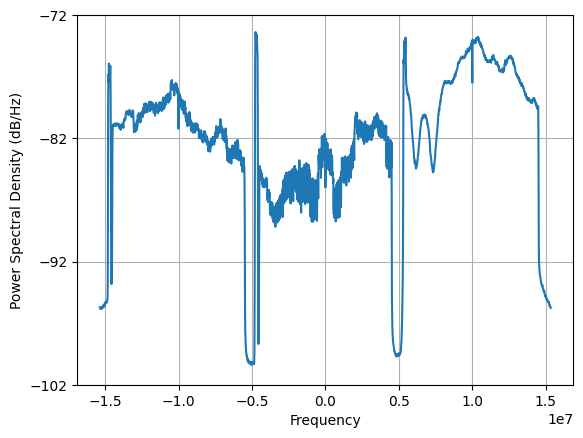

In [671]:
Pxx, ff = plt.psd(rx, Fs=Fs, NFFT=2048)
plt.show()

We have three-frequencies LTE signal, each occupies 9 MHz. <br>
The subcarrier of a downlink LTE signal is 15 KHz. <br>
Therefore, it uses 9MHz/15KHz = 600 subcarriers. <br>
Now we need to extract the most strong LTE signal portion by first down-convert to baseband and apply a LPF. <br>
Modulated signal: $r_n = x_n*e^{j\cdot 2\pi\cdot fc\cdot n/Fs}$

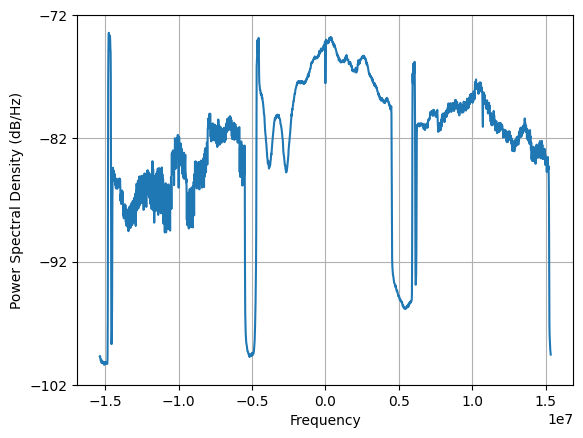

In [672]:
fc = 10e6
rxf_unfiltered = rx*np.exp(-2j*np.pi*fc*np.arange(len(rx))/Fs)

Pxx, ff = plt.psd(rxf_unfiltered, Fs=Fs, NFFT=2048)
plt.show()

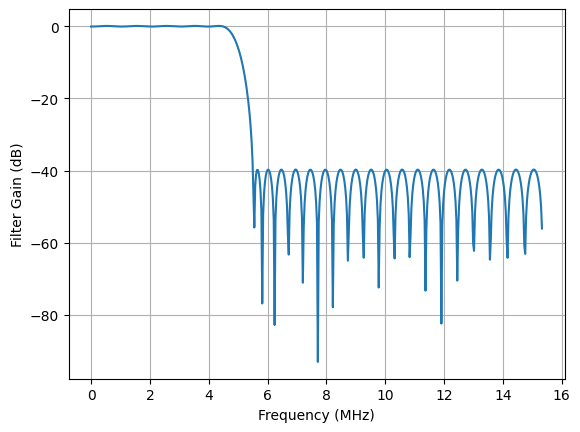

In [673]:
# design an FIR filter with (one-sided) bandwidth 4.5MHz
h = signal.remez(60, [0, 4.5e6, 5.5e6, Fs/2], [1, 0], fs=Fs)
w, H = signal.freqz(h, fs=Fs)

plt.plot(w/1e6, 20*np.log10(np.abs(H)))
plt.grid()

plt.xlabel('Frequency (MHz)')
plt.ylabel('Filter Gain (dB)')

plt.show()

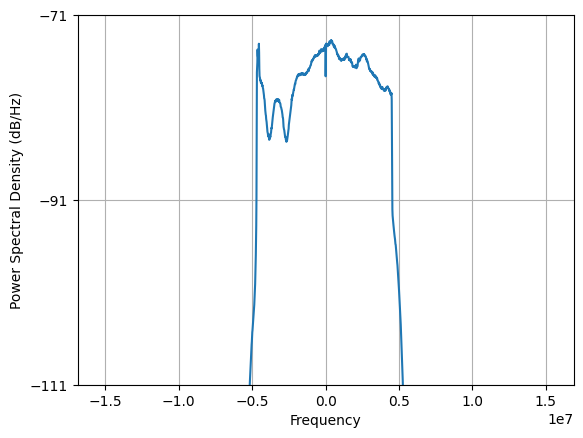

In [674]:
rxf = np.convolve(rxf_unfiltered,h)

Pxx, ff = plt.psd(rxf, Fs=Fs, NFFT=2048)
plt.ylim(-111,-71)
plt.show()

Now we look at frequency-time domain (spectrogram). <br>
Focus on the first subframe 1ms\*Fs = 30720 samples. <br>
An OFDM symbol occupies 1/15 kHz = 70 $\mu s$. <br>
A subframe contains 14 OFDM symbols.

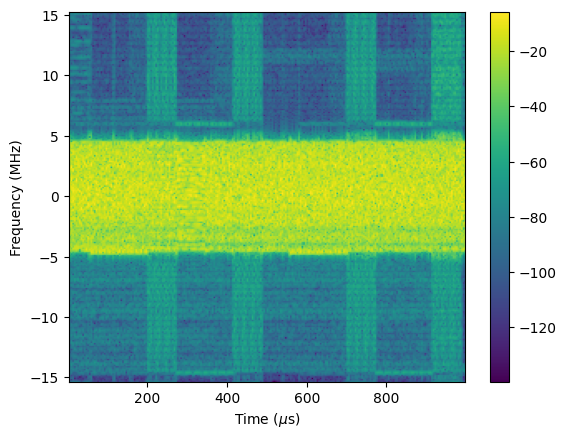

In [675]:
plt.specgram(rxf[:30720], Fs=Fs/1e6)
plt.colorbar()
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Frequency (MHz)')
plt.show()


An extra step is: <br>
Since the LTE signal is more than twice oversampled: Fs/10e6 $\approx$ 3, <br>
We can downsample the signal by 2 to save the signal processing complexity and remove unused subcarriers (10 MHz to 30 MHz -> 10 MHz to 15 MHz).

In [676]:
rxf = rxf[::2]
Fs = Fs//2

# system parameters
N_FFT = int(Fs//15e3)
N_CP = 144//2
N_CP_extra = 16//2

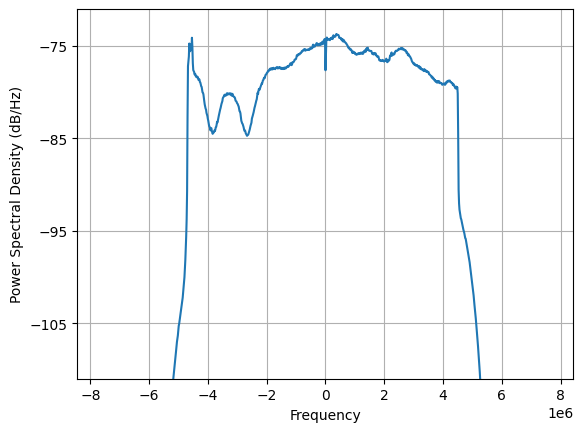

In [677]:
Pxx, ff = plt.psd(rxf, Fs=Fs, NFFT=N_FFT)
plt.ylim(-111,-71)
plt.show()

Now we decode the interested information from the LTE signal. <br>
The steps are: <br>
1. Determine frame boundary by PSS and SSS.
2. Decode MIB in PBCH.
3. Decode DCI in PDCCH.
4. Decode SIB in PDSCH.

Initial Synchronization: <br>
Match up with PSS and SSS.

PSS: TS 36.211 6.11.1, Eric 14.1.2 <br>
SSS: TS 36.211 6.11.2, Eric 14.1.3 <br>
In frequency domain, initial sync hasn't to know the cell bandwidth, <br>
In contrast, we know the maximum bandwidth (2048/2) and PSS and SSS are located at the middle. <br>
How to consider the DC carrier? Take 1024 subcarrier as an example. <br>
-512 ------- 0 --------511, thus, ---- -31 ----- -1 0 1 ----- 31 ---- <br>
Index: <br>
0 -------- 512 -------- 1023, ---- 512-31 ----- 512 ----- 512+31 ------ <br>
PSS or SSS is located in one OFDM symbol. <br>
We omit the effect of frequency offset at the time being. <br>

PSS: 63 zadoff-chu sequence

In [678]:
def seq_zadoff_chu(u):
    
    n = np.arange(63)
    d_u = np.exp(-1j*np.pi*u*n*(n+1)/63)
    d_u[31] = 0
    
    return d_u

In [679]:
def zadoff_chu(u,N_FFT):

    zc = seq_zadoff_chu(u)
    
    # mapping to resource elements
    re = np.zeros(N_FFT,complex)
    re[N_FFT//2-31:N_FFT//2+32] = zc
    
    # return time domain PSS
    return np.fft.ifft(np.fft.ifftshift(re)) 

    # shift, either fftshift or ifftshift is applied in frequency domain
    # the result of fft will have zeros at the original, you want to move to DC to see symmetric.
    # When you do ifft, you need first to move zeros to the original (as real freq domain be), then do ifft.

In [680]:
root_indices = [25,29,34]
zc = {} 

for n in range(len(root_indices)):
    zc[n] = {'u':root_indices[n],'sig':zadoff_chu(root_indices[n],N_FFT)} # this can be pre-defined

In [681]:
search = True
win = 1024
max_corr = 0
threshold = 0.6

# For every sliding window, correlate with each of the three PSS and compare with the threshold.
while search:
    
    rx = rxf[win-N_FFT:win]
    
    # This assumes the three PSS sequences are not highly correlated with each other.
    for n in range(3):
        pss = zc[n]['sig']
        corr = np.abs(np.sum(rx*np.conj(pss))/np.linalg.norm(rx)/np.linalg.norm(pss)) # the two norms can be precomputed
        
        if corr > threshold:
            # The correlation near the pss will decrease not fast. Thus we need to find the peak.
            if corr > max_corr:
                max_corr = corr
                N_id_2 = n
                pss_start = win-N_FFT
            else:
                search = False
            
    win += 1

print('Found pss starting at {:d} with N_id_2 = {:d}, the corr is {:1.2f}'.format(pss_start,N_id_2,max_corr))

Found pss starting at 363005 with N_id_2 = 0, the corr is 0.69


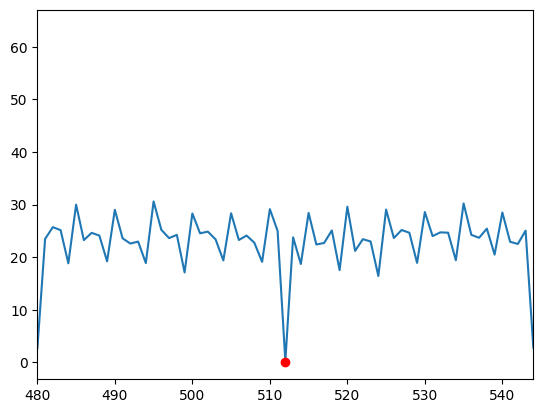

In [682]:
plt.plot(abs(np.fft.fftshift(np.fft.fft(rxf[pss_start:pss_start+N_FFT]))))
# The middle 65 numbers (the center 63 are PSS)
plt.xlim(N_FFT//2-32,N_FFT//2+32) # displayed value not index
plt.plot(N_FFT//2,0,'ro')
plt.show()

Use detected pss estimate frequency offset. <br>
For that purpose, we measure the phase difference over the two halves of the received PSS, so that the phase of the ZC signal is stripped off.


In [683]:
sig = rxf[pss_start:pss_start+N_FFT]
sig_zc = sig*np.conj(zc[N_id_2]['sig'])

pl = np.sum(sig_zc[:N_FFT//2])
pu = np.sum(sig_zc[N_FFT//2:])

f_d = np.angle(pu*np.conj(pl))/(2*np.pi*N_FFT//2) * Fs

f_d

1295.5441409791213

SSS: two interleaved length-31 m-sequence and scrambled with a sequence given by the primary synchronization signal. <br>
Right before PSS

In [684]:
def tilde_s():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+2] ^ x[i] # xor operation
                
    return 1-2.0*x

In [685]:
def tilde_c():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+3] ^ x[i] # xor operation
        
    return 1-2.0*x

In [686]:
def tilde_z():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+4] ^ x[i+2] ^ x[i+1] ^ x[i] # xor operation
        
    return 1-2.0*x

In [687]:
def m_01(N_id_1):
    
    q_prime = N_id_1 // 30
    q = (N_id_1 + q_prime*(q_prime+1)/2) // 30
    m_prime = N_id_1 + q*(q+1)/2
    m_0 = int(m_prime % 31)
    m_1 = int((m_0+m_prime//31+1) % 31)
    
    return (m_0,m_1)

assert 17,19 == m_01(47)

In [688]:
def m_sequence(N_id_1,N_id_2,F,N_FFT):
    
    # F: 0 or 1, denoting first half or second half
    
    m_0,m_1 = m_01(N_id_1)
    ts = tilde_s()
    tc = tilde_c()
    tz = tilde_z()
    # print(ts)
    
    c_0 = np.roll(tc,-N_id_2) # left cyclic shift operation 
    c_1 = np.roll(tc,-N_id_2-3) 
    
    s_0 = np.roll(ts,-m_0) 
    s_1 = np.roll(ts,-m_1) 
    
    z_10 = np.roll(tz,-(m_0%8))
    z_11 = np.roll(tz,-(m_1%8))
    
    d = np.zeros(62)
    if F == 0:
        
        d[0::2] = s_0 * c_0
        d[1::2] = s_1 * c_1 * z_10
    elif F == 1:
        
        d[0::2] = s_1 * c_0
        d[1::2] = s_0 * c_1 * z_11
                
    re = np.zeros(N_FFT)
    re[N_FFT//2-31:N_FFT//2] = d[:31]
    re[N_FFT//2+1:N_FFT//2+32] = d[31:]
    
    # return time domain SSS
    return np.fft.ifft(np.fft.ifftshift(re)) 

In [689]:
ms = {}

for N_id_1 in range(168):
    for F in range(2):
        n = N_id_1 + F*168
        ms[n] = {'N_id_1': N_id_1,'F': F,'sig': m_sequence(N_id_1,N_id_2,F,N_FFT)}

In [690]:
sss_start = pss_start - N_CP - N_FFT
sss_in_rx = rxf[sss_start:sss_start+N_FFT]
corr = np.zeros(336)

for i,info in ms.items(): # i: the top index, lower index
    sss = info['sig']
    corr[i] = np.abs(np.sum(sss_in_rx*np.conj(sss))/np.linalg.norm(sss_in_rx)/np.linalg.norm(sss))
    
max_corr_i = np.argmax(corr)
N_id_1 = ms[max_corr_i]['N_id_1']
F = ms[max_corr_i]['F']

print('Found the current slot in the {:s} half frame, with N_id_1 = {:d} and corr = {:1.2f}'.format('first' if F==0 else 'second',N_id_1,corr[max_corr_i]))

Found the current slot in the second half frame, with N_id_1 = 108 and corr = 0.69


In [691]:
N_id = N_id_1*3 + N_id_2
print('PCI: {:d}'.format(N_id))

PCI: 324


MIB Decoding: MIB is first transmitted by a transport block on BCH and then carried by PBCH for sending over the air. <br>
BCH: TS 36.212 5.3.1. Procedure: CRC attachment, channel coding, rate matching. <br>
PBCH: TS 36.211 6.6. Procedure: scrambling, modulation, layer mapping and precoding, mapping to resource elements. <br>
We need to care about the number of bits in each step (from ... to ...): <br>
CRC attachement: 24 to 40 bits, <br>
1/3 tail-bite convolutional coding: 40 to 40\*3 bits, <br>
Rate matching: 120 to 120\*16 bits, <br>
Scrambling: 1920 to 1920 bits, <br>
Modulation: 1920 to 960 symbols (QPSK), <br>
Layer mapping to precoding: 960 to 960 symbols (per antenna port), <br>
Demultiplexing at each antenna port: 960 to 240 symbols (each of four frames)

To start decoding cell system information, we should care two fundamental things: <br>
1. All processing is in frequency domain. This means we need to define an OFDM function to extract the right portion of resource in REs.
2. Channel Equalization by CRS should be done first. <br>

We first look at CRS function.
TS 6.10.1 and 7.2

In [692]:
# TS 36.211, 7.2
def c_sequence(M,c_init,Nc=1600):
    
    # M: required length of c sequence.
    # binary operation. The total required length of x_1 is M+Nc
    x_1 = np.zeros(M+Nc,dtype=np.uint8)
    x_1[0] = 1
    for n in range(31,M+Nc):
        x_1[n] = x_1[n-28] ^ x_1[n-31]
        
    x_2 = np.zeros(M+Nc,dtype=np.uint8)
    for n in range(31):
        x_2[n] = (c_init & (1<<n)) >> n # bitwise operator
    for n in range(31,M+Nc):
        x_2[n] = x_2[n-28] ^ x_2[n-29] ^ x_2[n-30] ^ x_2[n-31]
    
    return x_1[Nc:] ^ x_2[Nc:]    

In [693]:
# TS 36.211, 6.10.1.1
def crs_sequence(ns,l,N_id,N_cp=1,N_rb_max=110):
    
    # ns: slot number.
    # l: OFDM symbol number
    
    c_init = 2**10*(7*(ns+1)+l+1)*(2*N_id+1)+2*N_id+N_cp
    c = c_sequence(4*N_rb_max,c_init)
    
    return np.sqrt(0.5)*( (1-2.0*c[0::2]) + 1j*(1-2.0*c[1::2]) )

The point is that we know how CRS is mapped into REs. <br>
We use those CRS to evaluate the channel estimate for every RE in the mesh. <br>
We should note when first receiving BCH of a cell, the terminal can assume a cell bandwidth equal to the minimum possible downlink bandwidth (center 6 RB) to determine the value of CRS at positions. <br>
Another question is: How do we determine the number of antenna ports that is used before decoding MIB? <br>
Blindly search.

In [694]:
# TS 36.211 6.10.1.2, note figure.
def crs_in_re(p,l,ns,N_id,N_rb,N_rb_max=110):
    
    # p: antenna port number
    # l: OFDM symbol number
    # ns: slot number
    
    nu = -1
    if p == 0 and l == 0:
        nu = 0
    elif p == 0 and l == 4:
        nu = 3
    elif p == 1 and l == 0:
        nu = 3
    elif p == 1 and l == 4:
        nu = 0
    elif p == 2 and l == 1: 
        nu = 3*(ns%2) 
    elif p == 3 and l == 1:
        nu = 3 + 3*(ns%2) 
        
    if nu == -1:
        return (None,None)
        
    nu_shift = N_id % 6
    
    cs = crs_sequence(ns,l,N_id)
    
    m = np.arange(2*N_rb)
    m_prime = m + N_rb_max - N_rb
    crs = cs[m_prime] # value of crs
    
    k = 6*m + (nu + nu_shift) % 6 # index of crs
    
    return (k,crs) 

The last function that needs to be defined is the OFDM function because <br>
1. Cell system information (both MIB and SIB1) will be decoded in frequency domain.
2. We want to extract the exact REs that carry the information.

In [695]:
def extract_OFDM(ofdm_symbol,N_rb,N_rb_sc=12):
    
    re = np.fft.fftshift(np.fft.fft(ofdm_symbol))
    
    # length of occupied subcarriers
    N_sc = N_rb*N_rb_sc
    N_FFT = len(ofdm_symbol)
        
    # since we want to read the information in REs, we need to skip DC
    active_sc = np.concatenate((np.arange(N_FFT//2-N_sc//2,N_FFT//2),np.arange(N_FFT//2+1,N_FFT//2+N_sc//2+1)))
    
    return re[active_sc]

Now decoding the MIB. We only focus on 2 antennas are used. <br>
The reason for not blind search is that the number of antenna is fixed and we cannot test the correction of functions. <br>
We skip the signal processing step for determining the number of antenna since it won't occur in real-time signal processing, but we have to know how it works. <br>
We can compute the channel estimation for 4 ports (the positions of CRS transmitted at each port is unique). <br>
We look at both the amplitude and phase to see the port is used (a real complex number) or not (noise).

MIB decoding <br>
Preparation: CRS for four OFDM symbols. <br>
Note: correcting frequency offset is necessary.

In [696]:
half_frame = (Fs*5)//1000 # 5 ms 
pbch_start = pss_start + N_FFT + N_CP + N_CP_extra - F*half_frame # needs to be fit for F later

N_rb = 6
pbch = np.zeros((4,N_rb*12),dtype=complex)

s_pbch = rxf[pbch_start:pbch_start+4*N_FFT+3*N_CP]

s_pbch = s_pbch*np.exp(-2j*np.pi*f_d*np.arange(len(s_pbch))/Fs) # correcting freq offset is necessary

start = 0
for n in range(4):
    pbch[n][:] = extract_OFDM(s_pbch[start:start+N_FFT],N_rb)
    start += N_FFT + N_CP

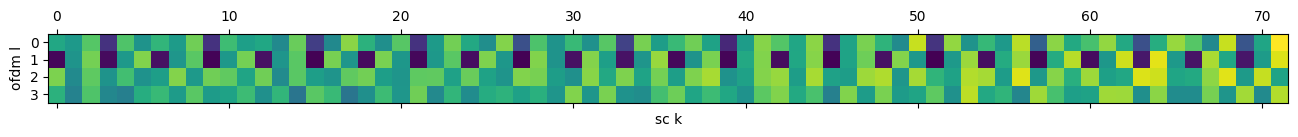

In [697]:
plt.matshow(np.abs(pbch))
plt.xlabel('sc k')
plt.ylabel('ofdm l')
plt.show()
# antenna port 2 is weak.

In [698]:
# we first see whether h from just symb 0 is sufficient to be intepolated to all four symbs in pbch
l = 0 
ns = 1

h_pbch = np.zeros((2,N_rb*12),dtype=complex)
for p in range(2):

    k,crs = crs_in_re(p,l,ns,N_id,N_rb)
    h_pbch[p][k] = pbch[l][k] * np.conj(crs)

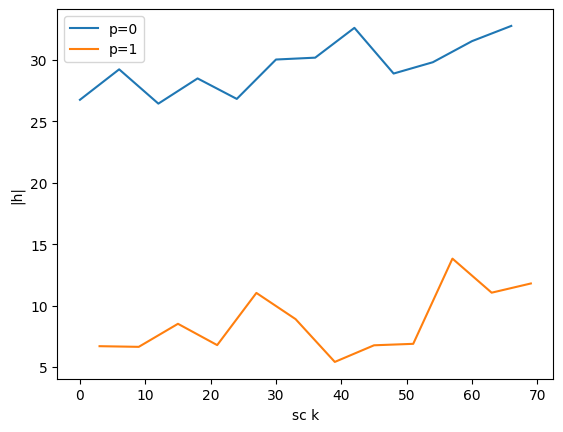

In [699]:
for p in range(2):
    k,crs = crs_in_re(p,l,ns,N_id,N_rb)
    plt.plot(k,np.abs(h_pbch[p][k]),label='p={:d}'.format(p))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.legend()
plt.show()

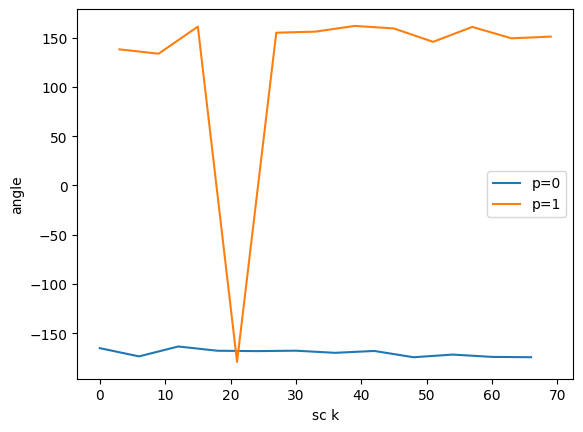

In [700]:
for p in range(2):
    k,crs = crs_in_re(p,l,ns,N_id,N_rb)
    plt.plot(k,np.angle(h_pbch[p][k])*180/np.pi,label='p={:d}'.format(p))
    
plt.xlabel('sc k')
plt.ylabel('angle')
plt.legend()
plt.show()

Something needs to be clarified. <br>
CRS are located at different ports uniquely. We can the channel estimate from CRS at different ports and then intepolated. <br>
We only convert back the channel estimate right before the transmitted at the transmitter. <br>
We only need to mitigate the channel estimate for one time when convert back before transmit diversity.
 

In [701]:
# intepolate
for p in range(2):
    
    k,crs = crs_in_re(p,l,ns,N_id,N_rb)
    for kk in range(72):
        n = k[np.argmin(np.abs(k - kk))]
        h_pbch[p][kk] = h_pbch[p][n]

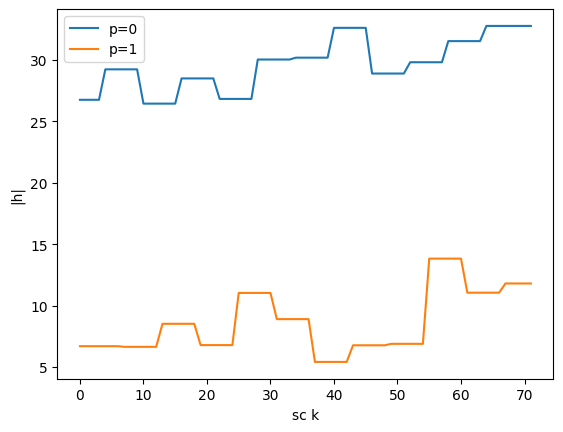

In [702]:
for p in range(2):
    plt.plot(np.abs(h_pbch[p]),label='p={:d}'.format(p))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.legend()
plt.show()

In [703]:
# extract pbch: each symbol with its channel estimate, collect the symbols from pbch and then exclude the crs.
tmp0 = np.zeros((4,72),complex)
tmp1 = np.zeros((4,72),complex)

ex_index = np.arange(0,72,3)
mask = np.ones(72, dtype=bool)
mask[ex_index] = False
r_pbch = np.array([], dtype=complex)
h0_pbch = np.array([], dtype=complex)
h1_pbch = np.array([], dtype=complex)

for l in range(4):
    # intepolate in time domain
    tmp0[l,:] = h_pbch[0]
    tmp1[l,:] = h_pbch[1]
    
    if l < 2:
        r_pbch = np.concatenate((r_pbch,pbch[l][mask]))
        h0_pbch = np.concatenate((h0_pbch,tmp0[l][mask]))
        h1_pbch = np.concatenate((h1_pbch,tmp1[l][mask]))

    else:
        r_pbch = np.concatenate((r_pbch,pbch[l]))
        h0_pbch = np.concatenate((h0_pbch,tmp0[l]))
        h1_pbch = np.concatenate((h1_pbch,tmp1[l]))

Layer mapping and precoding: transmit diversity. <br>
TS 36.211 6.3.3.3 and 6.3.4.3. <br>

\begin{aligned}
    &r(2n) = H^{(0)}(2n)d(2n) - H^{(1)}(2n)d(2n+1)^* \\
    &r(2n+1) = H^{(0)}{(2n+1)}d(2n+1) + H^{(1)}(2n+1)d(2n)^*
\end{aligned}

The transmitted symbols are computed by
\begin{aligned}
    &d(2n) = 1/H_a\cdot\big[H^{(1)}(2n)r(2n+1)^* + H^{(0)}(2n+1)^*r(2n)\big] \\
    &d(2n+1) = 1/H_a^*\cdot\big[H^{(0)}{(2n)}r(2n+1)^* - H^{(1)}(2n+1)^*r(2n)\big]^*
\end{aligned}
where $H_a = H^{(1)}(2n)H^{(1)}(2n+1)^*+H^{(0)}(2n+1)^*H^{(0)}{(2n)}$.






In [704]:
def SFBC_reverse(r,H0,H1):
    
    d = np.zeros_like(r)
    for n in range(len(r)//2):
        Ha = H0[2*n]*np.conj(H1[2*n+1]) + H0[2*n+1]*np.conj(H0[2*n])
        d[2*n] = (H1[2*n]*np.conj(r[2*n+1]) + np.conj(H0[2*n+1])*r[2*n])/Ha
        d[2*n+1] = np.conj((H0[2*n]*np.conj(r[2*n+1]) - np.conj(H1[2*n+1])*r[2*n])/Ha)
        
    return d

In [705]:
# def SFBC_reverse(r,H0,H1):
    
#     d = np.zeros_like(r)
        
#     scale = abs(H0[0::2])**2 + abs(H1[0::2])**2

#     d[0::2] =  (H0[0::2].conjugate() * r[0::2] + H1[0::2] * r[1::2].conjugate()) / scale
#     d[1::2] = ((-H1[0::2].conjugate() * r[0::2] + H0[0::2] * r[1::2].conjugate()) /scale).conjugate()
        
#     return d

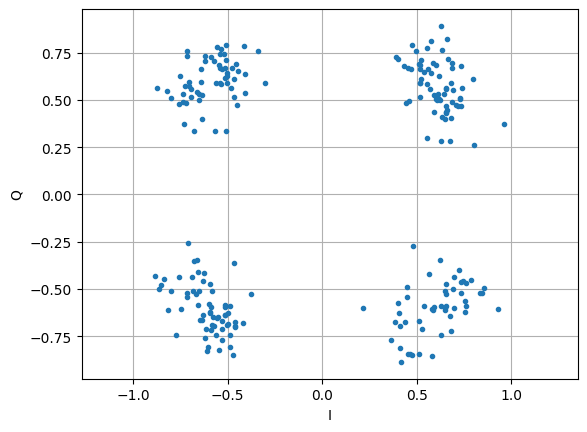

In [706]:
x_pbch = SFBC_reverse(r_pbch,h0_pbch,h1_pbch)

plt.plot(x_pbch.real,x_pbch.imag,'.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

Demodulation: qpsk

In [707]:
def qpsk_demodulate(x):
    "QPSK demodulate a sequence of observation"
    b = np.zeros(2*len(x), dtype=np.uint8)

    for n in range(len(x)):
        b[2*n] = 0 if np.real(x[n]) > 0 else 1
        b[2*n+1] = 0 if np.imag(x[n]) > 0 else 1

    return b

In [708]:
pbch_scrambled_bits = qpsk_demodulate(x_pbch)

pbch_scrambled_bits.size

480

Scrambling. <br>
TS 36.211 6.6.1 and 7.2 <br>
The scrambling sequence is generated primarily on 1920 bits. <br>
Since the transmitted bits are demultiplexed to 4 pieces, <br>
We need to figure out the right pieces and then de-scrambling. <br>
Because rate matching, the recovered bits will be repeated every 120 bits. <br>
Note, xor can be reversed by xor.



In [709]:
c = c_sequence(1920,N_id)
n_bits = len(pbch_scrambled_bits)

for n in range(4):
    pbch_bits = pbch_scrambled_bits ^ c[n*n_bits:(n+1)*n_bits]
    if np.all(pbch_bits[:10] == pbch_bits[120:130]):
        sec = n
        break

Rate matching. <br>
TS 5.3.1.3, 5.1.4.2 and Eric figure 10.5 <br>
The three steps are sub-block interleaving, bit collecting and selecting (pruning), repeating. <br>

Deinterleaving: since interleaving is essentially messing up the positions of the original bit sequence, <br>
The way of deinterleaving is to first know the interleaved positions, <br>
e.g., the position of interleaved bit at position 0 is the original bit at position of 9 (in our case). <br>
Use original[9] = interleaved[0] <br>
Note: We should do modular testing but due to time limitation, we omit this step.

In [710]:
def subblock_interleaver(seq,col_perm_table):
    "subblock interleaving of coded streams"
    N_cc = 32    
    D = len(seq)
    
    DUMMY = D+10

    R = D // N_cc
    if R * N_cc < D:
        R = R + 1
        
    # prepend dummy symbols, these 
    N_dummy = R*N_cc - D
    y = np.concatenate( (DUMMY *np.ones(N_dummy, dtype=seq.dtype), seq) )

    # read row-wise into a matrix
    M = np.reshape(y, (R, N_cc))
    
    # permute the columns of the matrix
    P = np.zeros_like(M)
    for n in range(N_cc):
        P[:, n] = M[:, col_perm_table[n]]

    # transpose and reshape P to give the output vector
    v = np.reshape(P.T, -1)

    # remove the dummy symbols
    e = v[v != DUMMY]

    return e

In [711]:
# the table for permuting columns of the matrix are given in TS 36.212,  Table 5.1.4-1
col_perm_table = np.array([1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31, 
                           0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30])

## construct the permutation table
ind  = np.arange(40)                   # indices 0 to 39
perm_table = subblock_interleaver(ind,col_perm_table) # pass indices to interleaver to obtain the permutation table

perm_table

array([ 9, 25, 17,  1, 33, 13, 29, 21,  5, 37, 11, 27, 19,  3, 35, 15, 31,
       23,  7, 39,  8, 24, 16,  0, 32, 12, 28, 20,  4, 36, 10, 26, 18,  2,
       34, 14, 30, 22,  6, 38])

In [712]:
pbch_coded_bits = np.zeros((3,40),dtype=np.uint8)

for n in range(3):
    pbch_coded_bits[n,perm_table] = pbch_bits[n*40:(n+1)*40] 
    
pbch_coded_bits    

array([[1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]],
      dtype=uint8)

Channel coding: 1/3 tail biting convolutional coding.
TS 36.212 5.3.1.3 and 5.1.3.1. <br>
Basic idea: <br>
1. define a grid: number of states by time.
2. define and work with te (current states), ts (previous states) and t (current bits from previous states to current states).
3. for each current input (0 or 1), compute path metric and add up with the previous cost of ts to get the current cost of te. Select the smaller one.
4. update cost and store input (also number of states by time at the end).
5. At the end, choose the input sequence (one row) with the smallest cost.
Tail biting: <br>

The length of the MIB bits is usually sufficient to produce a correct decoding. However, it is possible that the effect of initializing the state of the coder with the trailing 6 bits is not completely eliminated after 40 bits.

To circumvent any issues related to initialization, it is recommended practice with tail-biting to pass the observed sequence through the decoder twice and select the first half of decoded bits from the second pass and the second half of decoded bits from the first pass.

In [713]:
# helper function: count the number of 1-bits in an integer
def count_ones(n):
    "count the number of 1-bits in an integer"
    b = 0
    while n != 0:
        b += n & 0x1
        n = n >> 1

    return b

# helper function to find the total number of bits in an integer
def count_bits(n):
    "count the number of 0 and 1-bits in an integer"
    b = 0
    while n != 0:
        b += 0x1
        n = n >> 1

    return b

def hamming_dist(obs, ref):
    "Compute the Hamming distance between two sequences of integers"
    return np.sum( ref != obs)

In [714]:
class ConvCoder(object):
    "Class to implement convolution FEC coding"
    
    def __init__(self, generators_list):
        """The convolutional code is described by a list of generator polynomials. Each 
        generator polynomial is summarized by an integer that captures the connections from
        the shift register to the coded bits.
        
        From the generators, the structural properties of the code can be deduced:
        * the number of bits in the generators determines the length of the shift register
        * the number of generators determines the code rate

        The standard specifies three specific generators (`0o133`, `0o171`, and `0o165`) 
        for a rate 1/3 code with a constraint length of 6 delays in the shift register. 
        This implementation is generic and supports arbitrary generators.
        """
        self.n_codes = len(generators_list)
        self.order = max([count_bits(n) for n in generators_list]) - 1
        self.generators = generators_list

        self.Nt = 2 ** (self.order + 1) # number of prossible outputs in each bit period
        self.Ns = 2 ** self.order       # number of states of the shift register

        # table of possible outputs
        self._t = np.empty((self.Nt, self.n_codes), dtype=np.uint8)
        for n in range(self.Nt):
            # loop over all possible bit patterns of length order+1
            for m in range(self.n_codes):
                self._t[n, m] = count_ones(n & self.generators[m]) & 0x1

    def decode(self, d, cost_fun):
        """Decode a sequence of observations using the Viterbi algorithm
        
        Inputs:
        * d - 2D array of observations; leading dimension must be equal to self.n_codes
        * cost_fun - function to measure similarity; use `Hamming_dist` for hard decision observations,
                     and `L2_dist` for soft decisions

        Returns:
        vector of bits; length is equal to the second dimension of `d`
        """
        assert d.shape[0] == self.n_codes, "Leading dimension of d must match number of generators"

        # initialization
        N = d.shape[1]             # number of input observations; also number of outputs
        costs = np.zeros(self.Ns)  # accumulated similarity metric
        # sequences of estimated bits; one for each register state
        survivors = 127 * np.zeros([self.Ns, N], dtype=np.uint8)

        for n in range(N):
            # temporary storage for the following loops; these are updated during the first phase
            # and then copied to the permanent variables in the second phase. This is needed
            # to prevent that intermediate results are overwritten prematurely
            tmp_cost = np.inf * np.ones(self.Ns)
            # tmp_ts = np.zeros(self.Ns, dtype=np.uint8)
            tmp_b = np.zeros(self.Ns, dtype=np.uint8)
            tmp_survivors = survivors[:, :n].copy()  # this copy is critical - grrrr
            
            obs = d[:, n]  # outputs for this bit period

            # update costs and survivor extensions; the key to the algorithm is
            # that there are possible 2^7 bit patterns in each bit period. The 6 most
            # significant bits form the state at the end of the bit period. The 6 least
            # significant bits define the state at the start of the period. Hence, there
            # are only two possible beginning states to reach an end state. For each end state
            # we only keep the path that with the smaller cost metric. 
            for te in np.arange(self.Ns, dtype=np.uint8):
                # loop over all states at the end of this bit period
                for b in np.arange(2, dtype=np.uint8):
                    # loop ver the LSB of the beginning states; this is the 
                    # only bit that's not also in te
                    # b is the LSB of t and ts
                    t = (te << 1) + b      # t combines the bits of ts and te 
                    ts = t & (self.Ns - 1) # state at the start of period
                    # compute cost recursively: cost at the start of the priod +
                    # cost associated with the difference betwee observation and
                    # coded bits for this transition from ts to te
                    c = costs[ts] + cost_fun(obs, self._t[t, :])
                    #if n == 1 and c == 0:
                    #    print(te, t, ts, c, survivors[ts, :n])
                    if c < tmp_cost[te]:
                        # store results if this is the lowest cost path to te
                        tmp_cost[te] = c
                        # capture the MSB of t (and te); that's the current bit
                        tmp_b[te] = (t & self.Ns) >> (self.order)
                        # tmp_ts[te] = ts
                        tmp_survivors[te, :] = survivors[ts, :n]

            # copy the updates to permanent variables for next iteration
            for te in np.arange(self.Ns, dtype=np.uint8):
                costs[te] = tmp_cost[te]
                survivors[te, :n] = tmp_survivors[te, :]
                survivors[te, n] = tmp_b[te]

                #if n == 1 and costs[te] == 0:
                #    print(te, tmp_ts[te], tmp_b[te], tmp_survivors[te, :], survivors[te, :n+1])
                
        # all done, find the lowest cost and return the corrponding survivor
        ind_survivor = np.argmin(costs)
        return survivors[ind_survivor, :], costs[ind_survivor]


    def encode(self, bits, init_state=None):
        """convolutional encoder
        
        Inputs:
        bits - information bits to be encoded
        init_state - initial state for the register (default: initialize via tail-biting; i.e., 
        use last elements of bits)

        Returns:
        2D - array of coded bits; leading dimension equals the number of generators, second
             dimension equals the number of bits
        """
        d = np.zeros((self.n_codes, len(bits)), dtype=np.uint8)

        # initialize state; default via tailbiting
        ts = np.uint8(0)
        if init_state is None:
            for n in range(self.order):
                ts += (bits[-(n+1)] << (self.order - n -1))
        else:
            ts[:] = init_state[:]
        
        # print("Initial state: {:06b}".format(ts))

        # Encoder
        for n in range(len(bits)):
            # construct transition t from state ts and next bit
            t = ts + (bits[n] << self.order)
            # look up output in table
            d[:,n] = self._t[t, :]
            # update state
            ts = (t >> 1)
            
            #print("n = {:d} - bit = {:d} state = {:06b} ({:d} {:d} {:d})".format(n, bits[n], ts, d[0,n], d[1,n], d[2,n]))

        return d     

In [715]:
# modular check is very necessary that I should focus on later!
fec = ConvCoder([0o133, 0o171, 0o165])

test_mib = np.random.randint(0, 2, size=40)
coded_mib = fec.encode(test_mib)

decoded, cost = fec.decode(coded_mib, hamming_dist)

if cost == 0.0 and  np.sum(test_mib != decoded) == 0:
    print('Hard decsion: OK')
else:
    print('Hard decision: cost = {:f}, {:d} errors'.format(cost, np.sum(test_mib != decoded)) )

Hard decsion: OK


In [716]:
## decode for tail-biting
# pass two copies of received coded bits trough the decoder
decoded_2x, cost = fec.decode(np.concatenate((coded_mib, coded_mib), axis=1), hamming_dist)

# collect first 20 from second half and second 20 from first half
decoded = np.concatenate( (decoded_2x[40:60], decoded_2x[20:40]) )

# check
if cost == 0.0 and  np.sum(test_mib != decoded) == 0:
    print('Tail-biting: OK')
else:
    print('Tail-biting: cost = {:f}, {:d} errors'.format(cost, np.sum(test_mib != decoded)) )

Tail-biting: OK


In [717]:
pbch_hard_bits_2x,cost = fec.decode(np.concatenate((pbch_coded_bits,pbch_coded_bits),axis=1),hamming_dist)
pbch_hard_bits = np.concatenate((pbch_hard_bits_2x[40:60],pbch_hard_bits_2x[20:40])) # to avoid choosing the first 20 and the last 20

print('cost: {:1.0f}, hard bits: {:}'.format(cost,pbch_hard_bits))

cost: 0, hard bits: [0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0
 0 1 0]


CRC: <br>
TS 5.3.1.1 and 5.1.1.

In [718]:
class CRC16_Table(object):
    "Table driven CRC computation"

    def __init__(self, crc_poly):
        "compute the lookup table for byte-wise divisions"
        self.crc_poly = crc_poly

        self._t = np.zeros(256, dtype=np.uint16)
        mask = np.uint16(1 << 15)

        for n in np.arange(256, dtype=np.uint16):
            c = n << 8
            for k in range(8):
                if ((c & mask) != 0):
                    c = crc_poly ^ (c << 1)
                else:
                    c = c << 1

            self._t[n] = c

    def _update_crc(self, byte, prev_crc):
        return self._t[ ((prev_crc >> 8) ^ byte) & 0xFF] ^ (prev_crc << 8) & 0xFFFF

    def __call__(self, data):
        """Computes the CRC of data
        
        Input:
        * data - vector of bytes (uint8)

        Returns:
        integer containing the CRC; 0 indicates that data contains a valid CRC
        """
        crc = np.uint16(0)

        for d in data:
            crc = self._update_crc(d, crc)

        return crc & 0XFFFF

In [719]:
## Quick check
crc = CRC16_Table(0x1021)

# make a random 24-bit message, packed into three bytes
msg = np.packbits( np.random.randint(0, 2, size=24) )

# compute the CRC; result is a 16-bit integer
parity16 = crc(msg)

# append the parity bytes to msg; there is probably an easier way to converrt uint16 to two uint8
msg_par = np.concatenate((msg, np.array([parity16 // 256, parity16 % 256], dtype=np.uint8)))

# check: CRC of msg_par must be zero
if crc(msg_par) == 0:
    print('CRC OK')
else:
    print('CRC failed')

CRC OK


In [720]:
## Apply CRC to received bits
x_ant_d = {1: 0x00, 2: 0xFF, 4: 0x33}

crc_match = False

# retrieve bits for scrambling segment
bytes = np.packbits(pbch_hard_bits)

for n_ant, x_ant in x_ant_d.items():
    for n in [3,4]:
        # apply parity scrambling pattern
        bytes[n] = bytes[n] ^ x_ant

    if crc(bytes) == 0:
        N_ant = n_ant
        MIB_bytes = bytes[:3]
        crc_match = True

        break

if crc_match:
    print('Found MIB: {:}. System has {:d} antennas'.format(
                                        np.unpackbits(MIB_bytes), 
                                        N_ant))
else:
    print('no valid MIB found.')

Found MIB: [0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]. System has 2 antennas


Decode the MIB

In [721]:
import asn1tools

In [722]:
## provide the ASN1 specification
MIB_ASN1 = """
LTE DEFINITIONS ::= BEGIN

MasterInformationBlock ::= SEQUENCE {
dl-Bandwidth ENUMERATED {n6, n15, n25, n50, n75, n100},
phich-Config PHICH-Config,
systemFrameNumber BIT STRING (SIZE (8)),
schedulingInfoSIB1-BR-r13 INTEGER (0..31),
systemInfoUnchanged-BR-r15 BOOLEAN,
spare BIT STRING (SIZE (4))
}

PHICH-Config ::= SEQUENCE {
phich-Duration ENUMERATED {normal, extended},
phich-Resource ENUMERATED {oneSixth, half, one, two}
}

END
"""

# compile the spec
mib_spec = asn1tools.compile_string(MIB_ASN1, 'per')

# decode the MIB bytes
mib_info = mib_spec.decode('MasterInformationBlock', MIB_bytes)
mib_info

{'dl-Bandwidth': 'n50',
 'phich-Config': {'phich-Duration': 'normal', 'phich-Resource': 'one'},
 'systemFrameNumber': (b'\xea', 8),
 'schedulingInfoSIB1-BR-r13': 0,
 'systemInfoUnchanged-BR-r15': False,
 'spare': (b'\x00', 4)}

In [723]:
## it's a bit annoying that the SFN is given as a byte, let's turn that into an int
sfn_byte = mib_info['systemFrameNumber'][0]
sfn_mib = int.from_bytes(sfn_byte, "big")
sfn = sfn_mib * 4 + sec

print("the value of the SFN field is {:d}; The SFN is {:d}".format(sfn_mib, sfn))

the value of the SFN field is 234; The SFN is 938


In [724]:
BW_TABLE = {
    'n6': 6, 'n15': 15, 'n25': 25, 'n50': 50, 'n75': 75, 'n100': 100
}

N_rb_dl = BW_TABLE[mib_info['dl-Bandwidth']]
print('Downlink Bandwidth: {:d} Resource Blocks'.format(N_rb_dl))

Downlink Bandwidth: 50 Resource Blocks


Control region decoding: Decode PCFICH to know the region of control region (and traffic region) from CFI, and decode PDCCH to know the position of user data in traffice region from DCI. <br>
sib is located at subframe 5 of even SFN. We need to work on the corresponding control region.


PCFICH Decoding: <br>
TS 6.7, 5.3.4 and Eric 10.4.1. <br>
Channel coding: 32 bits. <br>
scrambling. <br>
modulation. <br>
Layer mapping and precoding. <br>
Note, we should focus more on how bits are mapped to REs for every control channel. <br>
In control channels, information are grouped into resource element group (REG). <br>
One REG contains four consecutive available REs. <br>
Control region is up to 3 ofdm symbols. <br>
Take first 12 REs and size-3 control region as an example: <br>
The number of control region is labeled as 0(0), 1(1), 2(2), 3(1), 4(2), 5(0), 6(1), 7(2), by focusing on looking at the start RE of the REG. <br>
PCFICH only locates at the first OFDM symbol. <br>
16 complex symbols every four located in one REG seperated by BW/4. 


Preparation: CRS.

In [725]:
subf5_start = pbch_start + int(4.5*Fs/1000)

# extract the samples for the PBCH
s_sym0 = rxf[subf5_start : subf5_start+N_FFT]

# and frequency correct (note: could re-estimate frequency offset here)
s_sym0 = s_sym0 * np.exp(-2j * np.pi * f_d * np.arange(len(s_sym0))/Fs)

# convert to frequency domain (entire bandwidth)
sym0 = extract_OFDM(s_sym0, N_rb_dl) 

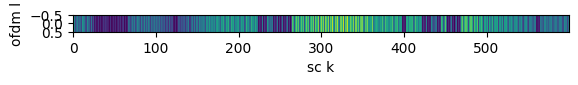

In [726]:
plt.imshow(np.abs(sym0.reshape(1, -1)), aspect=20)
plt.xlabel('sc k')
plt.ylabel('ofdm l')
plt.show()

In [727]:
l = 0 
ns = 10 # slot number

h_sym0 = np.zeros((2,N_rb_dl*12),dtype=complex)
for p in range(2):

    k,crs = crs_in_re(p,l,ns,N_id,N_rb_dl)
    h_sym0[p][k] = sym0[k] * np.conj(crs)

In [728]:
for p in range(2):
    
    k,crs = crs_in_re(p,l,ns,N_id,N_rb_dl)
    for kk in range(N_rb_dl*12):
        n = k[np.argmin(np.abs(k - kk))]
        h_sym0[p][kk] = h_sym0[p][n]

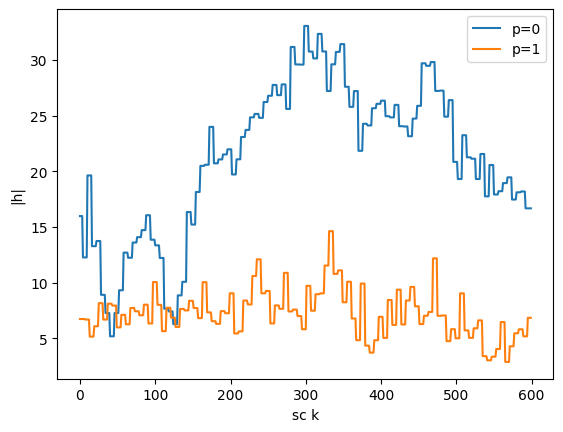

In [729]:
for p in range(2):
    plt.plot(np.abs(h_sym0[p]),label='p={:d}'.format(p))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.legend()
plt.show()

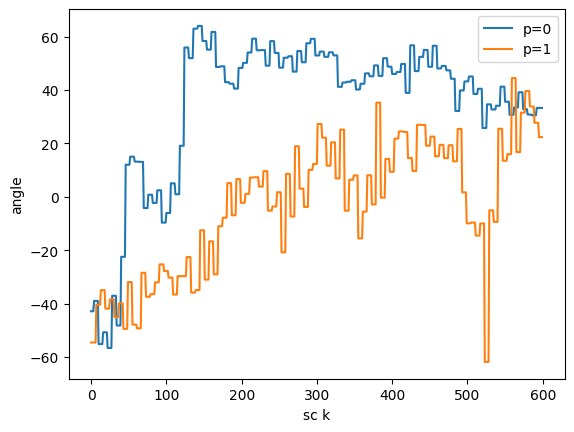

In [730]:
for p in range(2):
    plt.plot(np.angle(h_sym0[p])*180/np.pi,label='p={:d}'.format(p))
    
plt.xlabel('sc k')
plt.ylabel('angle')
plt.legend()
plt.show()

In [731]:
def PCFICH_locs(N_RB, N_id):
    """Compute subcarrier indices for PCFICH
    
    Inputs:
    N_RB - number of subcarriers 
    N_id - cell id

    Returns:
    length-16 vector of subcarrier indices
    """
    k_ind = np.zeros(16, dtype=int)

    N_SC_RB = 12
    N_SC_RB_2 = N_SC_RB // 2

    k_bar = N_SC_RB_2 * (N_id % (2 * N_RB))

    m = 0
    for n in range(4):
        # loop over quadruplets
        k_init = k_bar + ((n*N_RB) // 2) * N_SC_RB_2

        for i in range(6):
            if (i % 3) != 0:  # skip CRS
                k_ind[m] = (k_init + i) % (N_RB * N_SC_RB)
                m += 1

    return k_ind

In [732]:
cfi_k = PCFICH_locs(N_rb_dl, N_id)

r_pcfich = sym0[cfi_k]
h0_pcfich = h_sym0[0][cfi_k]
h1_pcfich = h_sym0[1][cfi_k]

cfi_k

array([145, 146, 148, 149, 295, 296, 298, 299, 445, 446, 448, 449, 595,
       596, 598, 599])

Layer mapping and precoding:

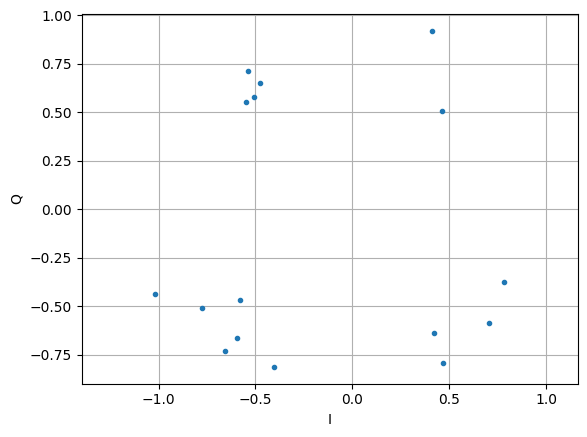

In [733]:
x_pcfich = SFBC_reverse(r_pcfich,h0_pcfich,h1_pcfich)

plt.plot(x_pcfich.real,x_pcfich.imag,'.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

Demodulation: qpsk

In [734]:
pcfich_scrambled_bits = qpsk_demodulate(x_pcfich)

pcfich_scrambled_bits.size

32

Scrambling

In [735]:
n_s = 10
c_init = (((n_s // 2 + 1) * (2 * N_id + 1)) << 9) + N_id

c = c_sequence(len(pcfich_scrambled_bits),c_init)

pcfich_bits = pcfich_scrambled_bits ^ c

Channel coding

In [736]:
## CFI decoding
# table of bit sequences for each CFI value (Table 5.3.4-1 in TS 36.212)
CFI_code_table = {
    1: np.array([0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1], dtype=np.uint8),
    2: np.array([1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0], dtype=np.uint8),
    3: np.array([1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1], dtype=np.uint8),
}

# compute distances
dist = np.zeros(3)
CFI_vec = np.zeros(3, dtype=int)

n = 0
for CFI_vec[n], cfi_seq in CFI_code_table.items():
    dist[n] = hamming_dist(pcfich_bits, cfi_seq)
    n += 1

obs_CFI = CFI_vec[np.argmin(dist)]

# When BW is low, CFI is one longer than indicated on PCFICH (see Table 6.7-1 in TS 36.211)
if N_rb_dl <= 10:
    CFI = obs_CFI + 1
else:
    CFI = obs_CFI

print('CFI = {:d}. Decoded CFI: hard: {:d} Hamming distance {:1.0f}'.format(
    CFI, obs_CFI, np.min(dist))
)

CFI = 1. Decoded CFI: hard: 1 Hamming distance 0


Before going to PDCCH decoding, let's first look at the potential position of SIB1 by looking at the spectrogram of subframe 5

In [737]:
s_subf5 = rxf[subf5_start : subf5_start + int(1*Fs/1000) - N_CP - N_CP_extra] 
# subf5_start is the starting position of the first symbol after CP.

s_subf5 = s_subf5 * np.exp(-2j * np.pi * f_d * np.arange(len(s_subf5)) / Fs) # dont forget this

subf5 = np.zeros((14, N_rb_dl*12), dtype=complex)

start = 0
for l in range(14):
    
    if l == 7:
        start += N_CP_extra
    
    subf5[l,:] = extract_OFDM(s_subf5[start:start+N_FFT],N_rb_dl)
    start += N_CP + N_FFT

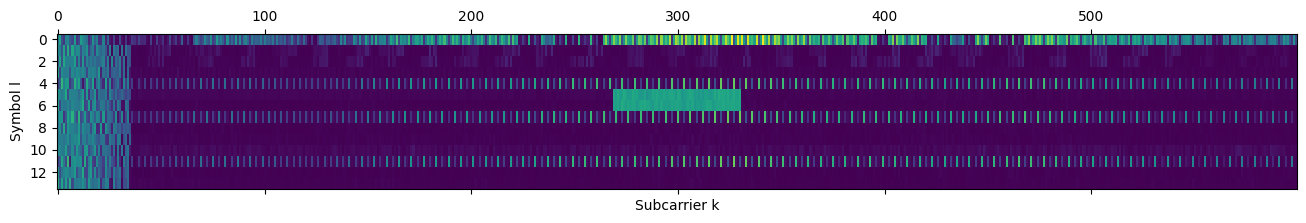

In [738]:
plt.matshow(np.abs(subf5),aspect='auto')
plt.xlabel('Subcarrier k')
plt.ylabel('Symbol l')

plt.show()

PDCCH Decoding: <br>
TS 36.211 6.8, TS 36.212 5.3.3 and Eric 10.4.8. <br>
CRC. <br>
Channel coding. <br>
Rate matching. <br>
PDCCH multiplexing and scrambling. <br>
modulation. <br>
layer mapping and precoding. <br>
mapping to resource element.

Mapping to resource element. <br>
we need to first figure out the positions of PHICH since the mapping of PDCCH should exclude PHICH. <br>
Thus, we first look at PHICH. <br>
TS 36.211 6.9.3 and Eric figure 10.24 <br>
The number of REGs of PCFICH is 4 (over the entire bandwidth). <br>
The number of REGs of PHICH is 3 (each over the entire bandwidth) times N_phich, in our case is 7. <br>
The only thing we should notice is that the location of PHICH should first extract the position of PCFICH and rearange the index from 0 to the end based on the available REGs.


In [739]:
## Figure out which REGS a re used by PCFICH, PHICH, and what is left
# start will all REGs
all_REG = {n for n in range(2*N_rb_dl)}

# PCFICH REGs are fairly easy 
PCFI_REG = {(N_id % (2*N_rb_dl) + ((n*N_rb_dl) // 2) % (2*N_rb_dl)) for n in range(4)}

# this is what's left for PHICH and PDCCH
all_REG.difference_update(PCFI_REG)
all_REG_vec = np.sort(np.array([n for n in all_REG]))
n_0 = len(all_REG)

# now deal with the PHICH
PHICH_REG = set()

# note: this is specific to FDD and normal CP
Ng = 1   # this reflects phich-Resource from MIB
N_group = (Ng * N_rb_dl) // 8
if 8*N_group < Ng * N_rb_dl:
    N_group += 1

for m in range(N_group):
    for i in range(3):
        n_i = (N_id + m + ((i*n_0) // 3)) % n_0 # index into all_REG_vec
        reg = all_REG_vec[n_i]   # the actual REG
        
        # move REG from all_REG to PHICH_REG
        all_REG.discard(reg)
        PHICH_REG.add(reg)
        
print("After PCFICH and PHICH, there are {:d} REGs left for the PDCCH".format(len(all_REG)))

After PCFICH and PHICH, there are 75 REGs left for the PDCCH


Mapping to resource elements: <br>
permute -> cyclically shift -> mapping follows the way of REGs. <br>
Note: We don't know how many bits are belonging to pdcch.

In [740]:
# later cater to control region of more than one OFDM symbol. Current only for one.
pdcch_reg = np.array(list(all_REG))
N_reg = len(pdcch_reg)

# de-cyclic shift
pdcch_reg_cs = np.roll(pdcch_reg,(N_id%N_reg))

# de-interleaving
ind  = np.arange(N_reg)                   
perm_table = subblock_interleaver(ind,col_perm_table)

pdcch_num_reg = np.zeros(N_reg,dtype=np.uint8)
pdcch_num_reg[perm_table] = pdcch_reg_cs

# extract the corresponding symbols in sym0 and h_sym0
pdcch = np.zeros(N_reg*4,dtype=complex)
h_pdcch = np.zeros((2,N_reg*4),dtype=complex)

k = 0
for n in pdcch_num_reg:
    for m in [1,2,4,5]: # skip crs
        pdcch[k] = sym0[6*n+m]
        for p in range(2):
            h_pdcch[p,k] = h_sym0[p,6*n+m]
        k += 1

Layer mapping and precoding:

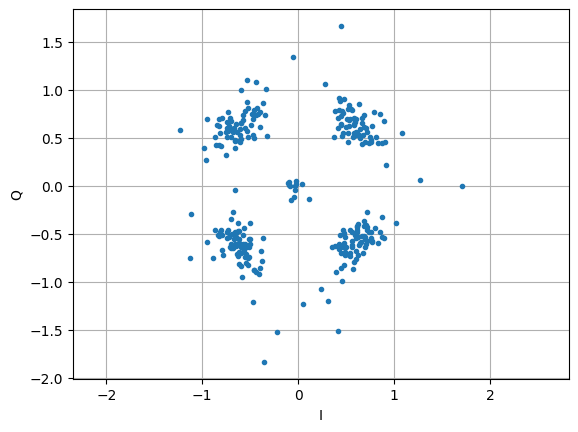

In [741]:
x_pdcch = SFBC_reverse(pdcch,h_pdcch[0],h_pdcch[1])

plt.plot(x_pdcch.real,x_pdcch.imag,'.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

Demodulation: qpsk

In [742]:
pdcch_scrambled_bits = qpsk_demodulate(x_pdcch)

pdcch multiplexing and scrambling: <br>
Multiplexing because multiple user data can be carried in the traffic region. <br>
we descrambling based on the entire pdcch symbols first, then demultiplexing. <br>
In TS 6.8.2, the number of scrambled bits is M_tot


In [743]:
ns = 10
c_init = ((ns // 2) << 9) + N_id

c = c_sequence(len(pdcch_scrambled_bits), c_init)

pdcch_bits = pdcch_scrambled_bits ^ c

Now we should know the block size of one pdcch. 
TS 36.211 6.8.1 <br>
pdcch uses four types of pdcch, which occupies 1, 2, 4 ,8 CCEs, one CCE occupies 9 consecutive REGs. <br>
The start of CCE should be fully modulo by the size of pdcch, e.g., 8 CCEs should start at 0, 8 or multiples of 8. <br>
Blind search is needed to test for every possibilities. <br>
In our case, the available CCE is equal to 8. The rest of symbols, 75\*4-8\*36=12 are useless bits (NIL in TS) for complementing (at the end).
We start with CCE 8 

For rate matching we should also know the transport block size. <br>
We need another degree of blind search of the tpye and size of DCI format. <br>
For cell search, it is primarily DCI format 1A (not super sure DCI format 1C). <br>
Since the size of DCI can be not a multiplier of pdcch, <br>
Based on bit collection of TS 36.212 5.1.4.2.2, it will circularly choose the first piece of bits to fill up the length of pdcch.

In [744]:
pdcch_f20 = pdcch_bits[:20]

for n in range(len(pdcch_bits)):
    if np.all(pdcch_f20 == pdcch_bits[n+1:n+1+20]):
        dci_len_3x = n+1
        break

In [745]:
# construct the permutation table
l_dci = dci_len_3x//3

ind  = np.arange(l_dci)                   
perm_table = subblock_interleaver(ind,col_perm_table) # pass indices to interleaver to obtain the permutation table

In [746]:
pdcch_coded_bits = np.zeros((3,l_dci),dtype=np.uint8)

for n in range(3):
    pdcch_coded_bits[n,perm_table] = pdcch_bits[n*l_dci:(n+1)*l_dci] 

In [747]:
pdcch_hard_bits, cost = fec.decode(pdcch_coded_bits,hamming_dist)

print("cost = {:f}, bits = {:}".format(cost, pdcch_hard_bits))

cost = 1.000000, bits = [1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0
 1 0 0 0 0 0]


CRC: <br>
One thing should be noted: the parity bits are scrambled by SI-RNTI. <br>
The value of SI-RNTI can be checked in TS 36.321 7.1, and equaling to FFFF

In [748]:
n_dci = l_dci-16

dci_bits = pdcch_hard_bits[:n_dci]
parity_bits = pdcch_hard_bits[n_dci:] ^ 1

pdcch_crc_bits = np.concatenate([dci_bits,parity_bits])

crc_match = False

bytes = np.packbits(pdcch_crc_bits)

if crc(bytes) == 0:
    crc_match = True

assert crc_match == True

In [749]:
pdcch_hard_bits

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
      dtype=uint8)

In [750]:
print('bits of dci: {:}'.format(dci_bits))

bits of dci: [1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0]


In [751]:
dci_bits.size

27

The 27-bit DCI shows:
- 1: format 1A
- 0: localized VRB
- [0 0 0 0 1 1 0 0 1 0 0]: resource indication value (RIV) is 100
    - $RB_{start}=0$, $L_{CRBs}=3$. BTW, the starting PDSCH symbol = the number of CFI (1)
- [0 0 1 1 0]: modulation and coding scheme ($I_{MCS}$) is 6
    - $Q_m = 2$ (modulation order), $I_{TBS} = 6 = I_{MCS}$, $N_{PRB}^{1A} = 2$, $TBS = 176$
- [0 0 0]: HARQ process number
- 0: new data indicator
- [1 0]: redundency version is 2
- [0 0]: TPC command for PUCCH. The LSB determines $N_{PRB}^{1A} = 2$.
- 0: N-Gap 1



SIB1 decoding:
TS 36.211 6.4, TS 36.212 5.3.2 and Eric 10.1 <br>
TBS = 176
CRC: from 176 to 200 <br>
code block segmentation and code block CRC attachment. no <br>
Channel coding. 204*3 <br> 
Rate matching. <br>
Code block concatenation. no <br>
scrambling. <br>
Modulation. <br>
Layer mapping. <br>
Precoding. <br>
Mapping to resource elements. <br>

Decoding SIB1 should be careful thus we should first understand the way how SIB1 is transmitted at every step. <br>
Some questions and answers: <br>
1. What should be a SIB1 look like? (We can know DCI from 5.3.3.1 but ...) <br>
TS 36.331 6.2.2 system information block type 1 (very long).
2. CRC <br>
one process + 24-bit parity bits (change the original crc).
3. Code block segmentation and code block CRC attachment. <br>
B = A+L. Seperate into r code blocks each with K_r bits. <br>
B > Z = 6144 will be segmented. In our case, there is no segmentation thus no concatenation as well. <br>
4. Channel coding: <br>
Turbo coding with rate 1/3. The resulting bits size = input size + 4 (x3). 

Rate matching. <br>
Sub-block interleaver: <br>
1. The top two bit stream performs the same sub-block interleaver as before but with a different pattern. 
2. The bottom bit stream is different but can be figured out. <br> 

Bit collection: <br>
1. The top bit stream all comes to the first k_pi positions of the circular buffer.
2. The bottom two bit streams are interleaved to be put to the next 2 k_pi positions. <br>

Bit selection: <br>
1. E is the total number of bits available for the transmission. In our case, should be 3 RBs times 13 slots - CRS.
2. R = ceil(204/32) = 7. k_0 = 322, k_w = 612, should have replication.

Scrambling. <br>
TS 36.211 6.3.1. <br> 
1. q = 0
2. n_RNTI is SI-RNTI = 0xFFFF
3. ns = 10: the scrambling sequence generator shall be initialized at the start of each subframe.
4. M_bit = one SIB1 block. no demultiplexing. Different redundent version is reflected on data collection of rate matching.

modulation: qpsk. <br>
layer-mapping and precoding: same <br>
mapping: first frequency then time.

Mapping to resource element. <br>
Preparation: CRS

In [752]:
# system information from DCI
rb_pdsch_start = 0
N_rb_pdsch = 3
TBS = 176
rv = 2

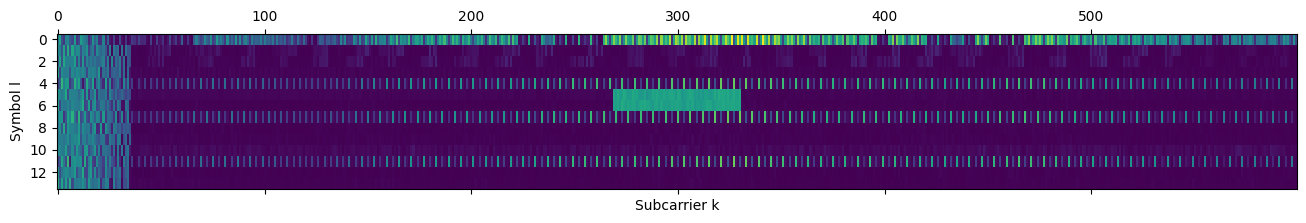

In [753]:
plt.matshow(np.abs(subf5),aspect='auto')
plt.xlabel('Subcarrier k')
plt.ylabel('Symbol l')

plt.show()

In [754]:
h_subf5 = np.zeros((2,4,N_rb_dl*12),dtype=complex)

for p in range(2):
    i = 0
    for l in [0,4,7,11]:
        if l < 7:
            ns = 10
        else:
            ns = 11
            
        k,crs = crs_in_re(p,l%7,ns,N_id,N_rb_dl)
        h_subf5[p][i][k] = subf5[l][k] * np.conj(crs)
        i += 1

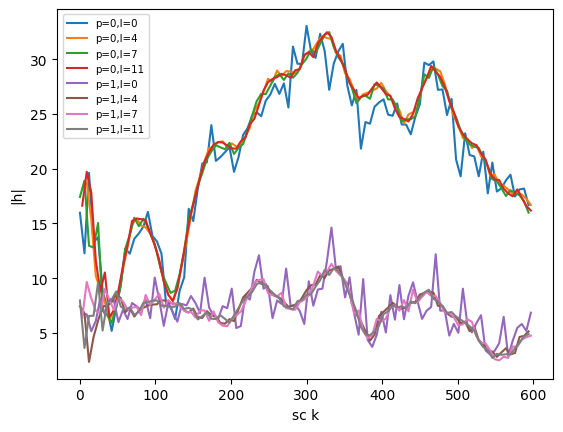

In [755]:
for p in range(2):
    i = 0
    for l in [0,4,7,11]:
        k,crs = crs_in_re(p,l%7,ns,N_id,N_rb_dl)
        plt.plot(k,np.abs(h_subf5[p][i][k]),label='p={:d},l={:d}'.format(p,l))
        i += 1
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.legend(fontsize=7.4)
plt.show()

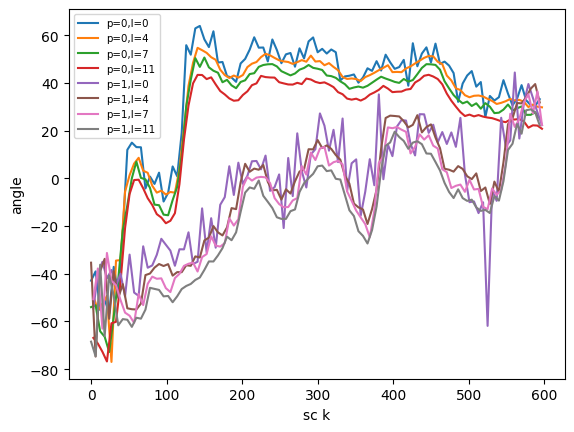

In [756]:
for p in range(2):
    i = 0
    for l in [0,4,7,11]:
        k,crs = crs_in_re(p,l%7,ns,N_id,N_rb_dl)
        plt.plot(k,np.angle(h_subf5[p][i][k])*180/np.pi,label='p={:d},l={:d}'.format(p,l))
        i += 1
    
plt.xlabel('sc k')
plt.ylabel('angle')
plt.legend(fontsize=7.4,loc='upper left')
plt.show()

In [757]:
# intepolate: frequency as before
for p in range(2):
    i = 0
    for l in [0,4,7,11]:
        if l < 7:
            ns = 10
        else:
            ns = 11
            
        k,crs = crs_in_re(p,l%7,ns,N_id,N_rb_dl)
        
        for kk in range(12*N_rb_dl):
            n = k[np.argmin(np.abs(k - kk))]
            h_subf5[p][i][kk] = h_subf5[p][i][n]
        
        i += 1    

In [758]:
for p in range(2):
    i = 0
    for l in [0,4,7,11]:
        if l < 7:
            ns = 10
        else:
            ns = 11
            
        k,crs = crs_in_re(p,l%7,ns,N_id,N_rb_dl)
        h_subf5[p][i][k] = subf5[l][k] * np.conj(crs)
        i += 1

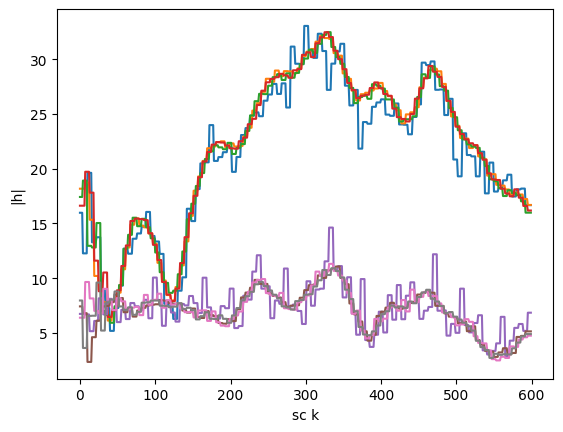

In [759]:
for p in range(2):
    for i in range(4):
        plt.plot(np.abs(h_subf5[p][i]))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.show()

In [760]:
tmp0 = np.zeros((14,12*N_rb_dl),complex)
tmp1 = np.zeros((14,12*N_rb_dl),complex)

ex_index = np.arange(0,N_rb_pdsch*12,3)
mask = np.ones(N_rb_pdsch*12,dtype=bool)
mask[ex_index] = False

r_pdsch = np.array([], dtype=complex)
h0_pdsch = np.array([], dtype=complex)
h1_pdsch = np.array([], dtype=complex) 

for l in range(14):
    # intepolate in time domain for entire subf5.
    # CRS at 0 for symbols 0 to 3, CRS at 4 for symbols 4 to 6.
    if l < 4:
        tmp0[l,:] = h_subf5[0][0]
        tmp1[l,:] = h_subf5[1][0]
    elif l < 7:
        tmp0[l,:] = h_subf5[0][1]
        tmp1[l,:] = h_subf5[1][1]
    elif l < 11:
        tmp0[l,:] = h_subf5[0][2]
        tmp1[l,:] = h_subf5[1][2]
    else:
        tmp0[l,:] = h_subf5[0][3]
        tmp1[l,:] = h_subf5[1][3]
        
    # extract real re for sib1    
    if l >= CFI:
        tmp = subf5[l][rb_pdsch_start*12:(rb_pdsch_start+N_rb_pdsch)*12]
        h_tmp0 = tmp0[l][rb_pdsch_start*12:(rb_pdsch_start+N_rb_pdsch)*12]
        h_tmp1 = tmp1[l][rb_pdsch_start*12:(rb_pdsch_start+N_rb_pdsch)*12]
        
        # exclude crs
        if l in [0,4,7,11]:
            r_pdsch = np.concatenate((r_pdsch,tmp[mask]))
            h0_pdsch = np.concatenate((h0_pdsch,h_tmp0[mask]))
            h1_pdsch = np.concatenate((h1_pdsch,h_tmp1[mask]))

        else:
            r_pdsch = np.concatenate((r_pdsch,tmp))
            h0_pdsch = np.concatenate((h0_pdsch,h_tmp0))
            h1_pdsch = np.concatenate((h1_pdsch,h_tmp1))

layer mapping and precoding:

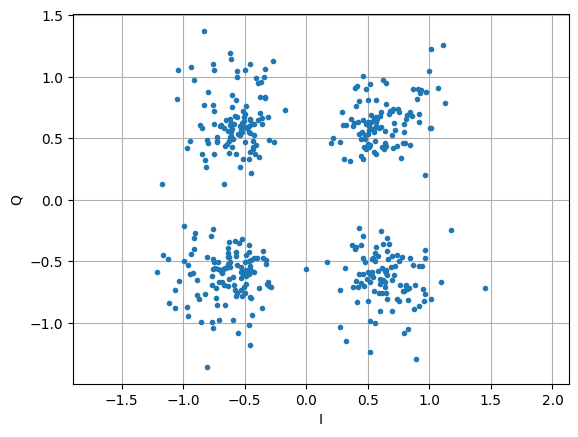

In [761]:
x_pdsch = SFBC_reverse(r_pdsch,h0_pdsch,h1_pdsch)

plt.plot(x_pdsch.real,x_pdsch.imag,'.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

Soft demodulation

In [762]:
def qpsk_demodulate_soft(x):
    "Soft decision QPSK demodulate a sequence of observation"
    b = np.zeros(2*len(x))

    b[0::2] = np.sqrt(2)*np.real(x)
    b[1::2] = np.sqrt(2)*np.imag(x)

    return b

In [763]:
pdsch_scrambled_bits = qpsk_demodulate_soft(x_pdsch)

pdsch_scrambled_bits.size

864

Soft scrambling

In [764]:
n_RNTI = 0xFFFF
ns = 10
q = 0
c_init = (n_RNTI << 14) + (q << 13) + ((ns // 2) << 9) + N_id

c = c_sequence(len(pdsch_scrambled_bits),c_init)

pdsch_bits = pdsch_scrambled_bits * (1.-2*c)

Rate matching:

In [765]:
# the table for permuting columns of the matrix are given in TS 36.212,  Table 5.1.4-1
col_perm_table = np.array([0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30,
                           1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31])

## construct the permutation table
l_sib1 = TBS + 24 + 4

ind  = np.arange(l_sib1)                   
perm_table = subblock_interleaver(ind,col_perm_table) # pass indices to interleaver to obtain the permutation table

perm_table

array([ 12,  44,  76, 108, 140, 172,  28,  60,  92, 124, 156, 188,  20,
        52,  84, 116, 148, 180,   4,  36,  68, 100, 132, 164, 196,  16,
        48,  80, 112, 144, 176,   0,  32,  64,  96, 128, 160, 192,  24,
        56,  88, 120, 152, 184,   8,  40,  72, 104, 136, 168, 200,  14,
        46,  78, 110, 142, 174,  30,  62,  94, 126, 158, 190,  22,  54,
        86, 118, 150, 182,   6,  38,  70, 102, 134, 166, 198,  18,  50,
        82, 114, 146, 178,   2,  34,  66,  98, 130, 162, 194,  26,  58,
        90, 122, 154, 186,  10,  42,  74, 106, 138, 170, 202,  13,  45,
        77, 109, 141, 173,  29,  61,  93, 125, 157, 189,  21,  53,  85,
       117, 149, 181,   5,  37,  69, 101, 133, 165, 197,  17,  49,  81,
       113, 145, 177,   1,  33,  65,  97, 129, 161, 193,  25,  57,  89,
       121, 153, 185,   9,  41,  73, 105, 137, 169, 201,  15,  47,  79,
       111, 143, 175,  31,  63,  95, 127, 159, 191,  23,  55,  87, 119,
       151, 183,   7,  39,  71, 103, 135, 167, 199,  19,  51,  8

In [766]:
k = np.arange(l_sib1)

C = 32
R = l_sib1 // C
if R * C < l_sib1:
    R = R + 1
    
pi_k = (col_perm_table[k//R] + C*(k%R) + 1) % l_sib1

pi_k

array([  1,  33,  65,  97, 129, 161, 193,  17,  49,  81, 113, 145, 177,
         5,   9,  41,  73, 105, 137, 169, 201,  25,  57,  89, 121, 153,
       185,  13,   5,  37,  69, 101, 133, 165, 197,  21,  53,  85, 117,
       149, 181,   9,  13,  45,  77, 109, 141, 173,   1,  29,  61,  93,
       125, 157, 189,  17,   3,  35,  67,  99, 131, 163, 195,  19,  51,
        83, 115, 147, 179,   7,  11,  43,  75, 107, 139, 171, 203,  27,
        59,  91, 123, 155, 187,  15,   7,  39,  71, 103, 135, 167, 199,
        23,  55,  87, 119, 151, 183,  11,  15,  47,  79, 111, 143, 175,
         3,  31,  63,  95, 127, 159, 191,  19,   2,  34,  66,  98, 130,
       162, 194,  18,  50,  82, 114, 146, 178,   6,  10,  42,  74, 106,
       138, 170, 202,  26,  58,  90, 122, 154, 186,  14,   6,  38,  70,
       102, 134, 166, 198,  22,  54,  86, 118, 150, 182,  10,  14,  46,
        78, 110, 142, 174,   2,  30,  62,  94, 126, 158, 190,  18,   4,
        36,  68, 100, 132, 164, 196,  20,  52,  84, 116, 148, 18

bit collection, selection and transmission

In [767]:
N_cb = int(l_sib1*3)
k0 = int(R*(2*np.ceil(N_cb/(8*R))*rv + 2))

# before selection
pdsch_bits = np.roll(pdsch_bits,k0)

# before collection
pdsch_bits = pdsch_bits[:N_cb]
pdsch_bits = np.concatenate([pdsch_bits[:l_sib1],pdsch_bits[l_sib1::2],pdsch_bits[l_sib1+1::2]])

pdsch_bits

array([-0.7274214 , -0.94897232, -0.50079601,  0.67427183, -1.11634909,
        0.65540891, -0.59819017, -0.83112479,  1.24153416, -1.25065322,
       -0.92881065,  0.43556017,  0.85035704, -1.2828387 ,  0.91258122,
        0.61577587,  0.95832529,  1.02332551,  0.85841615, -1.06783736,
       -1.18012879,  1.01963647,  1.06993018, -0.70700396,  0.92222837,
        1.13513021, -0.74141771,  1.10338523, -0.77468663,  0.49534857,
       -0.42095824,  0.85552645, -0.61708973,  0.67781296, -0.76249971,
       -0.37768718, -0.66254983, -0.69922506, -0.78409048, -0.60713621,
        0.95122476, -0.50344503,  1.13614853, -1.92097556, -0.4881352 ,
        1.40940505,  0.68865463, -1.2695752 , -1.32005867, -1.52327449,
        1.57207366,  1.18187754, -0.93866471,  1.21158465, -1.08169759,
        1.40431195, -0.508875  , -0.93486141,  1.06049074, -0.86832803,
        0.5757674 ,  0.93806572, -0.8120347 ,  0.59866833, -0.80024963,
       -0.84144499,  0.89204948, -0.57714562,  0.84905103, -0.81

Rate matching

In [768]:
pdsch_coded_bits = np.zeros((3,l_sib1))

for n in range(2):
    pdsch_coded_bits[n,perm_table] = pdsch_bits[n*l_sib1:(n+1)*l_sib1] 
    
pdsch_coded_bits[2,pi_k] = pdsch_bits[2*l_sib1:]

Compute output bits LLR

In [769]:
def bits_to_LLRs(bits, noise_sigma):
    return -2 * bits / noise_sigma**2

In [770]:
sib1_noise_sigma = 0.3
pdsch_LLR = np.zeros_like(pdsch_coded_bits)

for n in range(3):
    pdsch_LLR[n,:] = bits_to_LLRs(pdsch_coded_bits[n,:], sib1_noise_sigma)

Turbo decoding based on BCJR algorithm

In [771]:
def turbo_len(transport_size):
    pdsch_crc_len = 24
    turbo_tail = 4
    return transport_size + pdsch_crc_len + turbo_tail

In [772]:
# Table 5.1.3-3 in TS 36.212
def f1f2_table(K):
    return {
 40: (3, 10),
 48: (7, 12),
 56: (19, 42),
 64: (7, 16),
 72: (7, 18),
 80: (11, 20),
 88: (5, 22),
 96: (11, 24),
 104: (7, 26),
 112: (41, 84),
 120: (103, 90),
 128: (15, 32),
 136: (9, 34),
 144: (17, 108),
 152: (9, 38),
 160: (21, 120),
 168: (101, 84),
 176: (21, 44),
 184: (57, 46),
 192: (23, 48),
 200: (13, 50),
 208: (27, 52),
 216: (11, 36),
 224: (27, 56),
 232: (85, 58),
 240: (29, 60),
 248: (33, 62),
 256: (15, 32),
 264: (17, 198),
 272: (33, 68),
 280: (103, 210),
 288: (19, 36),
 296: (19, 74),
 304: (37, 76),
 312: (19, 78),
 320: (21, 120),
 328: (21, 82),
 336: (115, 84),
 344: (193, 86),
 352: (21, 44),
 360: (133, 90),
 368: (81, 46),
 376: (45, 94),
 384: (23, 48),
 392: (243, 98),
 400: (151, 40),
 408: (155, 102),
 416: (25, 52),
 424: (51, 106),
 432: (47, 72),
 440: (91, 110),
 448: (29, 168),
 456: (29, 114),
 464: (247, 58),
 472: (29, 118),
 480: (89, 180),
 488: (91, 122),
 496: (157, 62),
 504: (55, 84),
 512: (31, 64),
 528: (17, 66),
 544: (35, 68),
 560: (227, 420),
 576: (65, 96),
 592: (19, 74),
 608: (37, 76),
 624: (41, 234),
 640: (39, 80),
 656: (185, 82),
 672: (43, 252),
 688: (21, 86),
 704: (155, 44),
 720: (79, 120),
 736: (139, 92),
 752: (23, 94),
 768: (217, 48),
 784: (25, 98),
 800: (17, 80),
 816: (127, 102),
 832: (25, 52),
 848: (239, 106),
 864: (17, 48),
 880: (137, 110),
 896: (215, 112),
 912: (29, 114),
 928: (15, 58),
 944: (147, 118),
 960: (29, 60),
 976: (59, 122),
 992: (65, 124),
 1008: (55, 84),
 1024: (31, 64),
 1056: (17, 66),
 1088: (171, 204),
 1120: (67, 140),
 1152: (35, 72),
 1184: (19, 74),
 1216: (39, 76),
 1248: (19, 78),
 1280: (199, 240),
 1312: (21, 82),
 1344: (211, 252),
 1376: (21, 86),
 1408: (43, 88),
 1440: (149, 60),
 1472: (45, 92),
 1504: (49, 846),
 1536: (71, 48),
 1568: (13, 28),
 1600: (17, 80),
 1632: (25, 102),
 1664: (183, 104),
 1696: (55, 954),
 1728: (127, 96),
 1760: (27, 110),
 1792: (29, 112),
 1824: (29, 114),
 1856: (57, 116),
 1888: (45, 354),
 1920: (31, 120),
 1952: (59, 610),
 1984: (185, 124),
 2016: (113, 420),
 2048: (31, 64),
 2112: (17, 66),
 2176: (171, 136),
 2240: (209, 420),
 2304: (253, 216),
 2368: (367, 444),
 2432: (265, 456),
 2496: (181, 468),
 2560: (39, 80),
 2624: (27, 164),
 2688: (127, 504),
 2752: (143, 172),
 2816: (43, 88),
 2880: (29, 300),
 2944: (45, 92),
 3008: (157, 188),
 3072: (47, 96),
 3136: (13, 28),
 3200: (111, 240),
 3264: (443, 204),
 3328: (51, 104),
 3392: (51, 212),
 3456: (451, 192),
 3520: (257, 220),
 3584: (57, 336),
 3648: (313, 228),
 3712: (271, 232),
 3776: (179, 236),
 3840: (331, 120),
 3904: (363, 244),
 3968: (375, 248),
 4032: (127, 168),
 4096: (31, 64),
 4160: (33, 130),
 4224: (43, 264),
 4288: (33, 134),
 4352: (477, 408),
 4416: (35, 138),
 4480: (233, 280),
 4544: (357, 142),
 4608: (337, 480),
 4672: (37, 146),
 4736: (71, 444),
 4800: (71, 120),
 4864: (37, 152),
 4928: (39, 462),
 4992: (127, 234),
 5056: (39, 158),
 5120: (39, 80),
 5184: (31, 96),
 5248: (113, 902),
 5312: (41, 166),
 5376: (251, 336),
 5440: (43, 170),
 5504: (21, 86),
 5568: (43, 174),
 5632: (45, 176),
 5696: (45, 178),
 5760: (161, 120),
 5824: (89, 182),
 5888: (323, 184),
 5952: (47, 186),
 6016: (23, 94),
 6080: (47, 190),
 6144: (263, 480)}[K]

def turbo_permutation(K):
    f1, f2 = f1f2_table(K)
    i = np.arange(K)
    return (f1 * i + f2 * i**2) % K

def turbo_permutation_inv(K):
    fwd = list(turbo_permutation(K))
    return np.array([fwd.index(i) for i in range(K)])

In [773]:
def maxstar(a, b):
    result = np.empty_like(a)
    ainf = a == -np.inf
    binf = b == -np.inf
    result[ainf] = b[ainf]
    result[binf] = a[binf]
    noninf = (a != -np.inf) & (b != -np.inf)
    an = a[noninf]
    bn = b[noninf]
    result[noninf] = np.maximum(an, bn) + np.log1p(np.exp(-np.abs(an-bn)))
    return result

def BCJR(Ru, R, Ap):
    T = Ru.size # time steps
    nu = 3 # number of states = 2^nu
    Gamma = np.empty((T, 2**nu, 2**nu))
    Gamma[...] = -np.inf
    A = np.empty((T, 2**nu))
    A[...] = -np.inf
    A[0, 0] = 0
    B = np.empty((T, 2**nu))
    B[...] = -np.inf
    B[-1, 0] = 0
    
    # States are encoded as the concatenation of the
    # bits in the shift register, with the oldest bit
    # in the LSB, so that the shift register is shifted
    # left in each epoch.
    for r in range(2**nu):
        for s in range(2**nu):
            # non-termination trellis
            if r >> 1 == s & (2**(nu-1)-1):
                # S_r to S_s is a trellis edge
                Gamma[:-nu, r, s] = 0
                feedback = (r ^ (r >> 1)) & 1
                # The information bit corresponding to the
                # transition from S_r to S_s
                newbit = (s >> (nu - 1)) ^ feedback
                if newbit == 0:
                    Gamma[:-nu, r, s] += Ap - np.log1p(np.exp(Ap))
                else:
                    Gamma[:-nu, r, s] += -Ap - np.log1p(np.exp(-Ap))
                c0 = newbit
                c1 = (r ^ (r >> 2) ^ (s >> (nu - 1))) & 1                
                if c0 == 0:
                    Gamma[:-nu, r, s] += Ru[:-nu] - np.log1p(np.exp(Ru[:-nu]))
                else:
                    Gamma[:-nu, r, s] += -Ru[:-nu] - np.log1p(np.exp(-Ru[:-nu]))
                if c1 == 0:
                    Gamma[:-nu, r, s] += R[:-nu] - np.log1p(np.exp(R[:-nu]))
                else:
                    Gamma[:-nu, r, s] += -R[:-nu] - np.log1p(np.exp(-R[:-nu]))
            # termination trellis
            if r >> 1 == s:
                # S_r to S_s is a trellis edge
                Gamma[-nu:, r, s] = 0
                feedback = (r ^ (r >> 1)) & 1
                c0 = feedback
                c1 = (r ^ (r >> 2)) & 1
                if c0 == 0:
                    Gamma[-nu:, r, s] += Ru[-nu:] - np.log1p(np.exp(Ru[-nu:]))
                else:
                    Gamma[-nu:, r, s] += -Ru[-nu:] - np.log1p(np.exp(-Ru[-nu:]))
                if c1 == 0:
                    Gamma[-nu:, r, s] += R[-nu:] - np.log1p(np.exp(R[-nu:]))
                else:
                    Gamma[-nu:, r, s] += -R[-nu:] - np.log1p(np.exp(-R[-nu:]))

    # Note: For A, t is numbered from 0 to T-1,
    # while for Gamma and B, it is numbered from 1 to T
    for t in range(1, T):
        for r in range(2**nu):
            A[t, :] = maxstar(A[t, :], A[t-1, r] + Gamma[t-1, r, :])

    for t in range(T-2, -1, -1):
        for s in range(2**nu):
            B[t, :] = maxstar(B[t, :], B[t+1, s] + Gamma[t+1, :, s])
    
    M = A[:, :, np.newaxis] + Gamma + B[:, np.newaxis, :]

    Lp = np.empty_like(Ap)
    Lm = np.empty_like(Ap)
    Lp[:] = -np.inf
    Lm[:] = -np.inf
    for r in range(2**nu):
        for s in range(2**nu):
            # always non-termination trellis
            if r >> 1 == s & (2**(nu-1)-1):
                feedback = (r ^ (r >> 1)) & 1
                newbit = (s >> (nu - 1)) ^ feedback
                if newbit == 1:
                    Lp = maxstar(Lp, M[:-nu, r, s])
                else:
                    Lm = maxstar(Lm, M[:-nu, r, s])
    return Lm - Lp

def turbo_decoder(Ru1, R1, Ru2, R2, num_iterations=10, maxA=512, maxR=512, do_plots=False):
    for R in [Ru1, R1, Ru2, R2]:
        R[:] = np.clip(R, -maxR, maxR)
    K = Ru1.size - 3
    E2 = np.zeros(K)
    for iteration in range(num_iterations):
        A1 = E2[turbo_permutation_inv(K)]
        A1 = np.clip(A1, -maxA, maxA)
        L1 = BCJR(Ru1, R1, A1)
        E1 = L1 - Ru1[:-3] - A1        
        A2 = E1[turbo_permutation(K)]
        A2 = np.clip(A2, -maxA, maxA)
        L2 = BCJR(Ru2, R2, A2)
        E2 = L2 - Ru2[:-3] - A2
        if do_plots:
            fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
            axs[0].plot(L1, '.')
            axs[1].plot(L2, '.', color='C1')
            axs[0].set_ylabel('L1')
            axs[1].set_ylabel('L2')
            fig.suptitle(f'LTE Turbo decoder iteration {iteration}', y=0.93)
            axs[1].set_xlabel('Message bit')
            plt.subplots_adjust(hspace=0)
    return L2[turbo_permutation_inv(K)]

def LTE_turbo_decoder(LLRs, transport_size, plot_channel_LLRs=False, **kwargs):
  
    if plot_channel_LLRs:
        plt.figure()
        plt.plot(LLRs.ravel(), '.')
        plt.title('LTE Turbo decoder channel LLRs')
    # Section 5.1.3.2.2 in TS 36.212 for trellis termination "shuffling"
    K = turbo_len(transport_size) - 4
    # x
    Ru1 = np.concatenate([LLRs[0, :K], [LLRs[0, K], LLRs[2, K], LLRs[1, K+1]]])
    # z
    R1 = np.concatenate([LLRs[1, :K], [LLRs[1, K], LLRs[0, K+1], LLRs[2, K+1]]])
    # x'
    Ru2 = np.concatenate([LLRs[0, :K][turbo_permutation(K)], [LLRs[0, K+2], LLRs[2, K+2], LLRs[1, K+3]]])
    # z'
    R2 = np.concatenate([LLRs[2, :K], [LLRs[1, K+2], LLRs[0, K+3], LLRs[2, K+3]]])
    return turbo_decoder(Ru1, R1, Ru2, R2, **kwargs)

In [774]:
sib1_LLRs = LTE_turbo_decoder(pdsch_LLR*4, TBS)

In [780]:
pdsch_LLR

array([[-19.01169896, -20.42835965, -30.40286504,  17.41665534,
        -19.07591434, -15.51611924,  18.14535212,   9.15252857,
         10.84744883,  26.55955214,  16.00033095,  15.46347969,
         16.16491998,  11.81247212, -26.26394523,  11.72841947,
        -25.22511572,  14.23641262,   9.61655192,  12.13666437,
        -18.89682307,  34.46231498, -13.30374075, -18.44342571,
         17.4242329 ,  24.92023556,  24.09518088, -18.95187392,
         13.2931148 ,  19.30434338,  20.7746981 ,  31.91176259,
         13.71310522,  17.32484927,  14.7614769 , -17.34336351,
         23.72971908, -21.76567351,   9.67671322, -26.91019028,
        -31.32011213,  14.77864672,  21.82534323,  11.1242868 ,
         21.08827374, -18.80282429,  20.85921583,  27.21151321,
         16.47594907,  31.89603253, -15.34577212,  19.69957892,
         28.50752675, -20.92187124,  17.78332517,  16.57282836,
         13.49191579, -19.40540444,  12.0033743 , -19.7314258 ,
         18.46943985, -16.3049595 , -23.

Text(0.5, 1.0, 'Turbo decoder output for soft-combining')

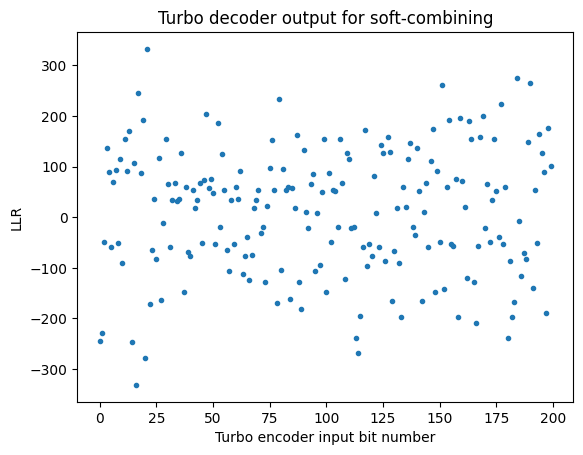

In [775]:
plt.plot(sib1_LLRs, '.')
plt.xlabel('Turbo encoder input bit number')
plt.ylabel('LLR')
plt.title('Turbo decoder output for soft-combining')

In [776]:
pdsch_hard_bytes = np.packbits(sib1_LLRs < 0)

pdsch_hard_bytes[0] = 10

CRC: for 24 length.

In [777]:
crc24a_table = [
  0x00000000,0x00864cfb,0x008ad50d,0x000c99f6,0x0093e6e1,0x0015aa1a,0x001933ec,0x009f7f17,
  0x00a18139,0x0027cdc2,0x002b5434,0x00ad18cf,0x003267d8,0x00b42b23,0x00b8b2d5,0x003efe2e,
  0x00c54e89,0x00430272,0x004f9b84,0x00c9d77f,0x0056a868,0x00d0e493,0x00dc7d65,0x005a319e,
  0x0064cfb0,0x00e2834b,0x00ee1abd,0x00685646,0x00f72951,0x007165aa,0x007dfc5c,0x00fbb0a7,
  0x000cd1e9,0x008a9d12,0x008604e4,0x0000481f,0x009f3708,0x00197bf3,0x0015e205,0x0093aefe,
  0x00ad50d0,0x002b1c2b,0x002785dd,0x00a1c926,0x003eb631,0x00b8faca,0x00b4633c,0x00322fc7,
  0x00c99f60,0x004fd39b,0x00434a6d,0x00c50696,0x005a7981,0x00dc357a,0x00d0ac8c,0x0056e077,
  0x00681e59,0x00ee52a2,0x00e2cb54,0x006487af,0x00fbf8b8,0x007db443,0x00712db5,0x00f7614e,
  0x0019a3d2,0x009fef29,0x009376df,0x00153a24,0x008a4533,0x000c09c8,0x0000903e,0x0086dcc5,
  0x00b822eb,0x003e6e10,0x0032f7e6,0x00b4bb1d,0x002bc40a,0x00ad88f1,0x00a11107,0x00275dfc,
  0x00dced5b,0x005aa1a0,0x00563856,0x00d074ad,0x004f0bba,0x00c94741,0x00c5deb7,0x0043924c,
  0x007d6c62,0x00fb2099,0x00f7b96f,0x0071f594,0x00ee8a83,0x0068c678,0x00645f8e,0x00e21375,
  0x0015723b,0x00933ec0,0x009fa736,0x0019ebcd,0x008694da,0x0000d821,0x000c41d7,0x008a0d2c,
  0x00b4f302,0x0032bff9,0x003e260f,0x00b86af4,0x002715e3,0x00a15918,0x00adc0ee,0x002b8c15,
  0x00d03cb2,0x00567049,0x005ae9bf,0x00dca544,0x0043da53,0x00c596a8,0x00c90f5e,0x004f43a5,
  0x0071bd8b,0x00f7f170,0x00fb6886,0x007d247d,0x00e25b6a,0x00641791,0x00688e67,0x00eec29c,
  0x003347a4,0x00b50b5f,0x00b992a9,0x003fde52,0x00a0a145,0x0026edbe,0x002a7448,0x00ac38b3,
  0x0092c69d,0x00148a66,0x00181390,0x009e5f6b,0x0001207c,0x00876c87,0x008bf571,0x000db98a,
  0x00f6092d,0x007045d6,0x007cdc20,0x00fa90db,0x0065efcc,0x00e3a337,0x00ef3ac1,0x0069763a,
  0x00578814,0x00d1c4ef,0x00dd5d19,0x005b11e2,0x00c46ef5,0x0042220e,0x004ebbf8,0x00c8f703,
  0x003f964d,0x00b9dab6,0x00b54340,0x00330fbb,0x00ac70ac,0x002a3c57,0x0026a5a1,0x00a0e95a,
  0x009e1774,0x00185b8f,0x0014c279,0x00928e82,0x000df195,0x008bbd6e,0x00872498,0x00016863,
  0x00fad8c4,0x007c943f,0x00700dc9,0x00f64132,0x00693e25,0x00ef72de,0x00e3eb28,0x0065a7d3,
  0x005b59fd,0x00dd1506,0x00d18cf0,0x0057c00b,0x00c8bf1c,0x004ef3e7,0x00426a11,0x00c426ea,
  0x002ae476,0x00aca88d,0x00a0317b,0x00267d80,0x00b90297,0x003f4e6c,0x0033d79a,0x00b59b61,
  0x008b654f,0x000d29b4,0x0001b042,0x0087fcb9,0x001883ae,0x009ecf55,0x009256a3,0x00141a58,
  0x00efaaff,0x0069e604,0x00657ff2,0x00e33309,0x007c4c1e,0x00fa00e5,0x00f69913,0x0070d5e8,
  0x004e2bc6,0x00c8673d,0x00c4fecb,0x0042b230,0x00ddcd27,0x005b81dc,0x0057182a,0x00d154d1,
  0x0026359f,0x00a07964,0x00ace092,0x002aac69,0x00b5d37e,0x00339f85,0x003f0673,0x00b94a88,
  0x0087b4a6,0x0001f85d,0x000d61ab,0x008b2d50,0x00145247,0x00921ebc,0x009e874a,0x0018cbb1,
  0x00e37b16,0x006537ed,0x0069ae1b,0x00efe2e0,0x00709df7,0x00f6d10c,0x00fa48fa,0x007c0401,
  0x0042fa2f,0x00c4b6d4,0x00c82f22,0x004e63d9,0x00d11cce,0x00575035,0x005bc9c3,0x00dd8538]

def crc24a(data):
    crc = 0
    for d in data:
        tbl_idx = ((crc >> 16) ^ d) & 0xff
        crc = (crc24a_table[tbl_idx] ^ (crc << 8)) & 0xffffff
    return crc & 0xffffff

In [778]:
crc_match = False
if crc24a(pdsch_hard_bytes) == 0:
    crc_match = True

assert crc_match == True

SIB1_bytes = pdsch_hard_bytes[:-3]

AssertionError: 

In [633]:
asn1_file = 'lte-rrc-15.6.0.asn1'
asn1 = asn1tools.compile_files(asn1_file, 'uper')

In [634]:
asn1.decode('BCCH-DL-SCH-Message', SIB1_bytes)

{'message': ('messageClassExtension', {})}

In [635]:
# byte_string = SIB1_bytes.tobytes()

# # Convert the byte string to a hex string
# hex_string = byte_string.hex()

# hex_string